In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import abstract_gradient_training as agt
import sklearn
import copy
import gurobipy as gp
from gurobipy import GRB
import json
from tqdm import tqdm
import random
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots

In [ ]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
# dev = "cpu"
device = torch.device(dev)
print(f"Using device: {device}")

Using device: cpu


In [4]:
save_dir  = ".prop_results/fa"

In [10]:
# get data
ensemble_size = 20
"""Initialise the halfmoons training data."""
seed = 0
total_dataset_size = 100000
train_dataset_size_per_member = total_dataset_size//ensemble_size  # number of samples per batch
batch_size = train_dataset_size_per_member // 2
test_size = 1000
# n_batches = 3  # number of batches per epoch
n_epochs = 4  # number of epochs
dpa_prop = 0.75 # proportion of data to use for DPA without AGT

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=ensemble_size*train_dataset_size_per_member + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))
# perform a test-train split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size / (ensemble_size*train_dataset_size_per_member + test_size), random_state=seed
)

# convert into pytorch dataloaders
x_train, y_train = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).to(device)
x_test, y_test = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).to(device)
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=250, shuffle=False)

In [49]:

"""Train an ensemble of classifiers on the AGT dataset."""
NOMINAL_CONFIG = agt.AGTConfig(
    learning_rate=3.0,
    n_epochs=4,
    device=dev,
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    log_level="DEBUG",
    # paired_poison=True,
    clip_gamma=1.0,
)

ensemble = []

d = 2
k = 20
ensemble_size = d * k
num_dpa = int(dpa_prop * ensemble_size)
ensemble = []
torch.manual_seed(seed)
indices = torch.randperm(len(dataset_train))
partitions = [t.tolist() for t in list(torch.chunk(indices, ensemble_size))]
# print(partitions)
shifts = random.sample(range(k), d)
# shifts = torch.arange(d).tolist()
print(shifts)

idxgroup = [[] for _ in range(ensemble_size)]
for i, h in enumerate(partitions):
    for shift in shifts:
        idxgroup[(i + shift)%ensemble_size] += h
# print(len(idxgroup))
# print([len(h) for h in idxgroup])
for t in range(ensemble_size):
    trained_models = []
    model_t = torch.nn.Sequential(
        torch.nn.Linear(7, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    ).to(device)
    conf = copy.deepcopy(NOMINAL_CONFIG)
    conf.n_epochs = 7
    if t >= num_dpa:
        # Smaller model for AGT
        print(f"Smaller model for AGT member {t}")
        model_t = torch.nn.Sequential(torch.nn.Linear(7, 2).to(device))
        conf.learning_rate = 2.0
        conf.n_epochs = 4
    bounded_model_t = agt.bounded_models.IntervalBoundedModel(model_t)
    torch.manual_seed(t)
    # create a disjoint subset of the training data
    dataset_train_t = torch.utils.data.Subset(dataset_train, idxgroup[t])  # type: ignore
    # print(len(dataset_train_t))
    dataloader_t = torch.utils.data.DataLoader(dataset_train_t, batch_size=batch_size, shuffle=True)
    ensemble.append((bounded_model_t, dataloader_t, conf))

[3, 6]
Smaller model for AGT member 30
Smaller model for AGT member 31
Smaller model for AGT member 32
Smaller model for AGT member 33
Smaller model for AGT member 34
Smaller model for AGT member 35
Smaller model for AGT member 36
Smaller model for AGT member 37
Smaller model for AGT member 38
Smaller model for AGT member 39


#### TRAINING

In [8]:
gridsize = 100
test_size = gridsize ** 2

# define a grid of points and add features
x0 = torch.linspace(-1.5, 2.5, gridsize)
x1 = torch.linspace(-1.2, 2.2, gridsize)
X0, X1 = torch.meshgrid(x0, x1)
X0f, X1f = X0.flatten(), X1.flatten()
grid_data = torch.stack((X0f, X1f, X0f**2, X1f**2, X0f * X1f, X0f ** 3, X1f ** 3), dim=1)
grid_data = grid_data.to(device)
print(grid_data.shape)

torch.Size([10000, 7])


/vol/bitbucket/spo21/myenv/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [51]:
# compute b up to N=5
n = len(grid_data)
m = len(ensemble)
b = torch.zeros((m, n)).to(device)
N = 8
s = 2


trained_ensemble = []
for (i, (bounded_model_t, dataloader_t, config)) in enumerate(ensemble):        
    trained_models = {}
    # Get the largest value of poisoned points before model prediction is no longer robust
    # Train models with different values of k, always compute for k_poison=N
    k_poisons = list(range(1, N+1, s)) + [N]  # include N as the last value
    if i < num_dpa:
        k_poisons = [1]
    for k_poison in k_poisons: # try by enumerating all values of k_poison
        model_copy = copy.deepcopy(bounded_model_t)
        print(f"Training model {i} with k={k_poison}")
        torch.manual_seed(i)
        conf = copy.deepcopy(config)
        conf.k_private = k_poison
        print(conf.device)
        # conf.epsilon = 0.01
        trained_model = agt.privacy_certified_training(model_copy, conf, dataloader_t, dataloader_test)
        trained_models[k_poison] = copy.deepcopy(trained_model)
    
        if k_poison == 1:
            trained_ensemble.append(copy.deepcopy(trained_model))
        
    if i < num_dpa:
        print(f"Setting b to 1 for model {i} (DPA)")
        b[i] = torch.ones(n).to(device)
        continue
    # tensor of size (1xlen(grid_data))
    bs = agt.privacy_utils.compute_max_certified_k(grid_data, trained_models) + 1
    b[i] = bs.clone()
    # print(bs)
torch.save(b, f"{save_dir}/moons_agt_bs_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")


[AGT] [INFO    ] [00:40:33] =================== Starting Privacy Certified Training ===================
[AGT] [DEBUG   ] [00:40:33] 	Optimizer params: n_epochs=7, learning_rate=3.0, l1_reg=0.0, l2_reg=0.0
[AGT] [DEBUG   ] [00:40:33] 	Learning rate schedule: lr_decay=0.6, lr_min=0.001
[AGT] [DEBUG   ] [00:40:33] 	Gradient clipping: gamma=1.0, method=clamp
[AGT] [DEBUG   ] [00:40:33] 	Privacy parameter: k_private=1
[AGT] [INFO    ] [00:40:33] Starting epoch 1 of 7.
[AGT] [DEBUG   ] [00:40:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:33] Batch 1. Loss (accuracy) 0.224 <= 0.224 <= 0.224


Training model 0 with k=1
cpu


[AGT] [INFO    ] [00:40:33] Batch 2. Loss (accuracy) 0.452 <= 0.468 <= 0.584
[AGT] [INFO    ] [00:40:33] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:33] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:40:34] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:40:34] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:34] Batch 1. Loss (accuracy) 0.000 <= 0.904 <= 1.000
[AGT] [INFO    ] [00:40:34] Batch 2. Loss (accuracy) 0.000 <= 0.868 <= 1.000
[AGT] [INFO    ] [00:40:34] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:34] Batch 1. Loss (accuracy) 0.000 <= 0.880 <= 1.000
[AGT] [INFO    ] [00:40:35] Batch 2. Loss (accuracy) 0.000 <= 0.908 <= 1.000
[AGT] [INFO    ] [00:40:35] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:35] Initialising datalo

Setting b to 1 for model 0 (DPA)
Training model 1 with k=1
cpu


[AGT] [INFO    ] [00:40:37] Batch 2. Loss (accuracy) 0.452 <= 0.456 <= 0.480
[AGT] [INFO    ] [00:40:38] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:38] Batch 1. Loss (accuracy) 0.388 <= 0.456 <= 0.816
[AGT] [INFO    ] [00:40:38] Batch 2. Loss (accuracy) 0.000 <= 0.516 <= 1.000
[AGT] [INFO    ] [00:40:38] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:38] Batch 1. Loss (accuracy) 0.000 <= 0.804 <= 1.000
[AGT] [INFO    ] [00:40:39] Batch 2. Loss (accuracy) 0.000 <= 0.812 <= 1.000
[AGT] [INFO    ] [00:40:39] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:39] Batch 1. Loss (accuracy) 0.000 <= 0.856 <= 1.000
[AGT] [INFO    ] [00:40:39] Batch 2. Loss (accuracy) 0.000 <= 0.888 <= 1.000
[AGT] [INFO    ] [00:40:39] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:39] Initialising datalo

Setting b to 1 for model 1 (DPA)
Training model 2 with k=1
cpu


[AGT] [INFO    ] [00:40:42] Batch 2. Loss (accuracy) 0.772 <= 0.820 <= 0.880
[AGT] [INFO    ] [00:40:42] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:42] Batch 1. Loss (accuracy) 0.000 <= 0.560 <= 1.000
[AGT] [INFO    ] [00:40:42] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:40:43] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:43] Batch 1. Loss (accuracy) 0.000 <= 0.828 <= 1.000
[AGT] [INFO    ] [00:40:43] Batch 2. Loss (accuracy) 0.000 <= 0.848 <= 1.000
[AGT] [INFO    ] [00:40:43] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:43] Batch 1. Loss (accuracy) 0.000 <= 0.852 <= 1.000
[AGT] [INFO    ] [00:40:44] Batch 2. Loss (accuracy) 0.000 <= 0.908 <= 1.000
[AGT] [INFO    ] [00:40:44] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:44] Initialising datalo

Setting b to 1 for model 2 (DPA)
Training model 3 with k=1
cpu


[AGT] [INFO    ] [00:40:46] Batch 2. Loss (accuracy) 0.736 <= 0.780 <= 0.828
[AGT] [INFO    ] [00:40:46] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:46] Batch 1. Loss (accuracy) 0.020 <= 0.788 <= 1.000
[AGT] [INFO    ] [00:40:47] Batch 2. Loss (accuracy) 0.000 <= 0.876 <= 1.000
[AGT] [INFO    ] [00:40:47] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:47] Batch 1. Loss (accuracy) 0.000 <= 0.916 <= 1.000
[AGT] [INFO    ] [00:40:47] Batch 2. Loss (accuracy) 0.000 <= 0.948 <= 1.000
[AGT] [INFO    ] [00:40:48] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:48] Batch 1. Loss (accuracy) 0.000 <= 0.940 <= 1.000
[AGT] [INFO    ] [00:40:48] Batch 2. Loss (accuracy) 0.000 <= 0.984 <= 1.000
[AGT] [INFO    ] [00:40:48] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:48] Initialising datalo

Setting b to 1 for model 3 (DPA)
Training model 4 with k=1
cpu


[AGT] [INFO    ] [00:40:50] Batch 2. Loss (accuracy) 0.460 <= 0.520 <= 0.620
[AGT] [INFO    ] [00:40:51] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:51] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 0.896
[AGT] [INFO    ] [00:40:51] Batch 2. Loss (accuracy) 0.000 <= 0.760 <= 1.000
[AGT] [INFO    ] [00:40:51] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:51] Batch 1. Loss (accuracy) 0.000 <= 0.864 <= 1.000
[AGT] [INFO    ] [00:40:52] Batch 2. Loss (accuracy) 0.000 <= 0.816 <= 1.000
[AGT] [INFO    ] [00:40:52] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:52] Batch 1. Loss (accuracy) 0.000 <= 0.828 <= 1.000
[AGT] [INFO    ] [00:40:52] Batch 2. Loss (accuracy) 0.000 <= 0.884 <= 1.000
[AGT] [INFO    ] [00:40:53] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:53] Initialising datalo

Setting b to 1 for model 4 (DPA)
Training model 5 with k=1
cpu


[AGT] [INFO    ] [00:40:55] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:40:55] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:55] Batch 1. Loss (accuracy) 0.452 <= 0.456 <= 0.660
[AGT] [INFO    ] [00:40:55] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:40:56] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:40:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:56] Batch 1. Loss (accuracy) 0.000 <= 0.840 <= 1.000
[AGT] [INFO    ] [00:40:56] Batch 2. Loss (accuracy) 0.000 <= 0.860 <= 1.000
[AGT] [INFO    ] [00:40:56] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:40:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:56] Batch 1. Loss (accuracy) 0.000 <= 0.876 <= 1.000
[AGT] [INFO    ] [00:40:57] Batch 2. Loss (accuracy) 0.000 <= 0.928 <= 1.000
[AGT] [INFO    ] [00:40:57] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:40:57] Initialising datalo

Setting b to 1 for model 5 (DPA)
Training model 6 with k=1
cpu


[AGT] [INFO    ] [00:40:59] Batch 2. Loss (accuracy) 0.592 <= 0.688 <= 0.756
[AGT] [INFO    ] [00:40:59] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:40:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:40:59] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 0.896
[AGT] [INFO    ] [00:41:00] Batch 2. Loss (accuracy) 0.000 <= 0.512 <= 1.000
[AGT] [INFO    ] [00:41:00] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:00] Batch 1. Loss (accuracy) 0.000 <= 0.924 <= 1.000
[AGT] [INFO    ] [00:41:00] Batch 2. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:41:01] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:01] Batch 1. Loss (accuracy) 0.000 <= 0.916 <= 1.000
[AGT] [INFO    ] [00:41:01] Batch 2. Loss (accuracy) 0.000 <= 0.956 <= 1.000
[AGT] [INFO    ] [00:41:01] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:01] Initialising datalo

Setting b to 1 for model 6 (DPA)
Training model 7 with k=1
cpu


[AGT] [INFO    ] [00:41:04] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:41:04] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:04] Batch 1. Loss (accuracy) 0.456 <= 0.456 <= 0.744
[AGT] [INFO    ] [00:41:04] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:41:04] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:04] Batch 1. Loss (accuracy) 0.000 <= 0.752 <= 1.000
[AGT] [INFO    ] [00:41:05] Batch 2. Loss (accuracy) 0.000 <= 0.788 <= 1.000
[AGT] [INFO    ] [00:41:05] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:05] Batch 1. Loss (accuracy) 0.000 <= 0.776 <= 1.000
[AGT] [INFO    ] [00:41:05] Batch 2. Loss (accuracy) 0.000 <= 0.896 <= 1.000
[AGT] [INFO    ] [00:41:06] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:06] Initialising datalo

Setting b to 1 for model 7 (DPA)
Training model 8 with k=1
cpu


[AGT] [INFO    ] [00:41:08] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:41:08] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:08] Batch 1. Loss (accuracy) 0.456 <= 0.456 <= 0.456
[AGT] [INFO    ] [00:41:08] Batch 2. Loss (accuracy) 0.000 <= 0.480 <= 1.000
[AGT] [INFO    ] [00:41:09] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:09] Batch 1. Loss (accuracy) 0.000 <= 0.800 <= 1.000
[AGT] [INFO    ] [00:41:09] Batch 2. Loss (accuracy) 0.000 <= 0.796 <= 1.000
[AGT] [INFO    ] [00:41:09] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:09] Batch 1. Loss (accuracy) 0.000 <= 0.820 <= 1.000
[AGT] [INFO    ] [00:41:10] Batch 2. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:41:10] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:10] Initialising datalo

Setting b to 1 for model 8 (DPA)
Training model 9 with k=1
cpu


[AGT] [INFO    ] [00:41:12] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:41:13] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:13] Batch 1. Loss (accuracy) 0.456 <= 0.456 <= 0.480
[AGT] [INFO    ] [00:41:13] Batch 2. Loss (accuracy) 0.000 <= 0.556 <= 1.000
[AGT] [INFO    ] [00:41:13] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:13] Batch 1. Loss (accuracy) 0.000 <= 0.840 <= 1.000
[AGT] [INFO    ] [00:41:13] Batch 2. Loss (accuracy) 0.000 <= 0.792 <= 1.000
[AGT] [INFO    ] [00:41:14] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:14] Batch 1. Loss (accuracy) 0.000 <= 0.800 <= 1.000
[AGT] [INFO    ] [00:41:14] Batch 2. Loss (accuracy) 0.000 <= 0.872 <= 1.000
[AGT] [INFO    ] [00:41:14] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:14] Initialising datalo

Setting b to 1 for model 9 (DPA)
Training model 10 with k=1
cpu


[AGT] [INFO    ] [00:41:17] Batch 2. Loss (accuracy) 0.752 <= 0.780 <= 0.796
[AGT] [INFO    ] [00:41:17] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:17] Batch 1. Loss (accuracy) 0.000 <= 0.884 <= 1.000
[AGT] [INFO    ] [00:41:17] Batch 2. Loss (accuracy) 0.000 <= 0.896 <= 1.000
[AGT] [INFO    ] [00:41:18] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:18] Batch 1. Loss (accuracy) 0.000 <= 0.940 <= 1.000
[AGT] [INFO    ] [00:41:18] Batch 2. Loss (accuracy) 0.000 <= 0.932 <= 1.000
[AGT] [INFO    ] [00:41:18] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:18] Batch 1. Loss (accuracy) 0.000 <= 0.940 <= 1.000
[AGT] [INFO    ] [00:41:18] Batch 2. Loss (accuracy) 0.000 <= 0.980 <= 1.000
[AGT] [INFO    ] [00:41:19] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:19] Initialising datalo

Setting b to 1 for model 10 (DPA)
Training model 11 with k=1
cpu


[AGT] [INFO    ] [00:41:21] Batch 2. Loss (accuracy) 0.780 <= 0.832 <= 0.860
[AGT] [INFO    ] [00:41:21] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:21] Batch 1. Loss (accuracy) 0.000 <= 0.816 <= 1.000
[AGT] [INFO    ] [00:41:22] Batch 2. Loss (accuracy) 0.000 <= 0.628 <= 1.000
[AGT] [INFO    ] [00:41:22] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:22] Batch 1. Loss (accuracy) 0.000 <= 0.844 <= 1.000
[AGT] [INFO    ] [00:41:22] Batch 2. Loss (accuracy) 0.000 <= 0.872 <= 1.000
[AGT] [INFO    ] [00:41:23] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:23] Batch 1. Loss (accuracy) 0.000 <= 0.896 <= 1.000
[AGT] [INFO    ] [00:41:23] Batch 2. Loss (accuracy) 0.000 <= 0.920 <= 1.000
[AGT] [INFO    ] [00:41:23] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:23] Initialising datalo

Setting b to 1 for model 11 (DPA)
Training model 12 with k=1
cpu


[AGT] [INFO    ] [00:41:25] Batch 2. Loss (accuracy) 0.768 <= 0.812 <= 0.828
[AGT] [INFO    ] [00:41:26] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:26] Batch 1. Loss (accuracy) 0.000 <= 0.816 <= 1.000
[AGT] [INFO    ] [00:41:26] Batch 2. Loss (accuracy) 0.000 <= 0.640 <= 1.000
[AGT] [INFO    ] [00:41:26] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:26] Batch 1. Loss (accuracy) 0.000 <= 0.820 <= 1.000
[AGT] [INFO    ] [00:41:27] Batch 2. Loss (accuracy) 0.000 <= 0.880 <= 1.000
[AGT] [INFO    ] [00:41:27] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:27] Batch 1. Loss (accuracy) 0.000 <= 0.852 <= 1.000
[AGT] [INFO    ] [00:41:27] Batch 2. Loss (accuracy) 0.000 <= 0.920 <= 1.000
[AGT] [INFO    ] [00:41:28] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:28] Initialising datalo

Setting b to 1 for model 12 (DPA)
Training model 13 with k=1
cpu


[AGT] [INFO    ] [00:41:30] Batch 2. Loss (accuracy) 0.508 <= 0.716 <= 0.776
[AGT] [INFO    ] [00:41:30] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:30] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:41:30] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:41:31] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:31] Batch 1. Loss (accuracy) 0.000 <= 0.924 <= 1.000
[AGT] [INFO    ] [00:41:31] Batch 2. Loss (accuracy) 0.000 <= 0.872 <= 1.000
[AGT] [INFO    ] [00:41:31] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:31] Batch 1. Loss (accuracy) 0.000 <= 0.884 <= 1.000
[AGT] [INFO    ] [00:41:32] Batch 2. Loss (accuracy) 0.000 <= 0.920 <= 1.000
[AGT] [INFO    ] [00:41:32] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:32] Initialising datalo

Setting b to 1 for model 13 (DPA)
Training model 14 with k=1
cpu


[AGT] [INFO    ] [00:41:34] Batch 2. Loss (accuracy) 0.724 <= 0.772 <= 0.804
[AGT] [INFO    ] [00:41:34] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:34] Batch 1. Loss (accuracy) 0.000 <= 0.764 <= 1.000
[AGT] [INFO    ] [00:41:35] Batch 2. Loss (accuracy) 0.000 <= 0.692 <= 1.000
[AGT] [INFO    ] [00:41:35] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:35] Batch 1. Loss (accuracy) 0.000 <= 0.888 <= 1.000
[AGT] [INFO    ] [00:41:35] Batch 2. Loss (accuracy) 0.000 <= 0.880 <= 1.000
[AGT] [INFO    ] [00:41:36] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:36] Batch 1. Loss (accuracy) 0.000 <= 0.896 <= 1.000
[AGT] [INFO    ] [00:41:36] Batch 2. Loss (accuracy) 0.000 <= 0.932 <= 1.000
[AGT] [INFO    ] [00:41:36] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:36] Initialising datalo

Setting b to 1 for model 14 (DPA)
Training model 15 with k=1
cpu


[AGT] [INFO    ] [00:41:38] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:41:39] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:39] Batch 1. Loss (accuracy) 0.300 <= 0.456 <= 0.808
[AGT] [INFO    ] [00:41:39] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:41:39] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:39] Batch 1. Loss (accuracy) 0.000 <= 0.812 <= 1.000
[AGT] [INFO    ] [00:41:40] Batch 2. Loss (accuracy) 0.000 <= 0.812 <= 1.000
[AGT] [INFO    ] [00:41:40] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:40] Batch 1. Loss (accuracy) 0.000 <= 0.776 <= 1.000
[AGT] [INFO    ] [00:41:40] Batch 2. Loss (accuracy) 0.000 <= 0.844 <= 1.000
[AGT] [INFO    ] [00:41:41] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:41] Initialising datalo

Setting b to 1 for model 15 (DPA)
Training model 16 with k=1
cpu


[AGT] [INFO    ] [00:41:43] Batch 2. Loss (accuracy) 0.800 <= 0.812 <= 0.844
[AGT] [INFO    ] [00:41:43] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:43] Batch 1. Loss (accuracy) 0.000 <= 0.900 <= 1.000
[AGT] [INFO    ] [00:41:43] Batch 2. Loss (accuracy) 0.000 <= 0.956 <= 1.000
[AGT] [INFO    ] [00:41:44] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:44] Batch 1. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:41:44] Batch 2. Loss (accuracy) 0.000 <= 0.812 <= 1.000
[AGT] [INFO    ] [00:41:44] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:44] Batch 1. Loss (accuracy) 0.000 <= 0.936 <= 1.000
[AGT] [INFO    ] [00:41:45] Batch 2. Loss (accuracy) 0.000 <= 0.972 <= 1.000
[AGT] [INFO    ] [00:41:45] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:45] Initialising datalo

Setting b to 1 for model 16 (DPA)
Training model 17 with k=1
cpu


[AGT] [INFO    ] [00:41:47] Batch 2. Loss (accuracy) 0.748 <= 0.792 <= 0.836
[AGT] [INFO    ] [00:41:48] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:48] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:41:48] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:41:48] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:48] Batch 1. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:41:48] Batch 2. Loss (accuracy) 0.000 <= 0.872 <= 1.000
[AGT] [INFO    ] [00:41:49] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:49] Batch 1. Loss (accuracy) 0.000 <= 0.848 <= 1.000
[AGT] [INFO    ] [00:41:49] Batch 2. Loss (accuracy) 0.000 <= 0.908 <= 1.000
[AGT] [INFO    ] [00:41:49] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:49] Initialising datalo

Setting b to 1 for model 17 (DPA)
Training model 18 with k=1
cpu


[AGT] [INFO    ] [00:41:52] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:41:52] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:52] Batch 1. Loss (accuracy) 0.444 <= 0.456 <= 0.776
[AGT] [INFO    ] [00:41:52] Batch 2. Loss (accuracy) 0.000 <= 0.848 <= 1.000
[AGT] [INFO    ] [00:41:53] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:53] Batch 1. Loss (accuracy) 0.000 <= 0.860 <= 1.000
[AGT] [INFO    ] [00:41:53] Batch 2. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:41:53] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:53] Batch 1. Loss (accuracy) 0.000 <= 0.908 <= 1.000
[AGT] [INFO    ] [00:41:53] Batch 2. Loss (accuracy) 0.000 <= 0.948 <= 1.000
[AGT] [INFO    ] [00:41:54] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:54] Initialising datalo

Setting b to 1 for model 18 (DPA)
Training model 19 with k=1
cpu


[AGT] [INFO    ] [00:41:56] Batch 2. Loss (accuracy) 0.764 <= 0.824 <= 0.856
[AGT] [INFO    ] [00:41:56] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:41:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:56] Batch 1. Loss (accuracy) 0.000 <= 0.616 <= 1.000
[AGT] [INFO    ] [00:41:57] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:41:57] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:41:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:57] Batch 1. Loss (accuracy) 0.000 <= 0.740 <= 1.000
[AGT] [INFO    ] [00:41:57] Batch 2. Loss (accuracy) 0.000 <= 0.840 <= 1.000
[AGT] [INFO    ] [00:41:58] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:41:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:41:58] Batch 1. Loss (accuracy) 0.000 <= 0.808 <= 1.000
[AGT] [INFO    ] [00:41:58] Batch 2. Loss (accuracy) 0.000 <= 0.864 <= 1.000
[AGT] [INFO    ] [00:41:58] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:41:58] Initialising datalo

Setting b to 1 for model 19 (DPA)
Training model 20 with k=1
cpu


[AGT] [INFO    ] [00:42:00] Batch 2. Loss (accuracy) 0.840 <= 0.860 <= 0.876
[AGT] [INFO    ] [00:42:01] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:01] Batch 1. Loss (accuracy) 0.268 <= 0.456 <= 0.988
[AGT] [INFO    ] [00:42:01] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:01] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:01] Batch 1. Loss (accuracy) 0.000 <= 0.776 <= 1.000
[AGT] [INFO    ] [00:42:02] Batch 2. Loss (accuracy) 0.000 <= 0.836 <= 1.000
[AGT] [INFO    ] [00:42:02] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:02] Batch 1. Loss (accuracy) 0.000 <= 0.836 <= 1.000
[AGT] [INFO    ] [00:42:02] Batch 2. Loss (accuracy) 0.000 <= 0.900 <= 1.000
[AGT] [INFO    ] [00:42:03] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:03] Initialising datalo

Setting b to 1 for model 20 (DPA)
Training model 21 with k=1
cpu


[AGT] [INFO    ] [00:42:05] Batch 2. Loss (accuracy) 0.760 <= 0.784 <= 0.804
[AGT] [INFO    ] [00:42:05] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:05] Batch 1. Loss (accuracy) 0.000 <= 0.904 <= 1.000
[AGT] [INFO    ] [00:42:05] Batch 2. Loss (accuracy) 0.000 <= 0.812 <= 1.000
[AGT] [INFO    ] [00:42:06] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:06] Batch 1. Loss (accuracy) 0.000 <= 0.936 <= 1.000
[AGT] [INFO    ] [00:42:06] Batch 2. Loss (accuracy) 0.000 <= 0.904 <= 1.000
[AGT] [INFO    ] [00:42:06] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:06] Batch 1. Loss (accuracy) 0.000 <= 0.932 <= 1.000
[AGT] [INFO    ] [00:42:07] Batch 2. Loss (accuracy) 0.000 <= 0.968 <= 1.000
[AGT] [INFO    ] [00:42:07] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:07] Initialising datalo

Setting b to 1 for model 21 (DPA)
Training model 22 with k=1
cpu


[AGT] [INFO    ] [00:42:09] Batch 2. Loss (accuracy) 0.688 <= 0.760 <= 0.784
[AGT] [INFO    ] [00:42:09] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:09] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:42:10] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:10] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:10] Batch 1. Loss (accuracy) 0.000 <= 0.884 <= 1.000
[AGT] [INFO    ] [00:42:10] Batch 2. Loss (accuracy) 0.000 <= 0.852 <= 1.000
[AGT] [INFO    ] [00:42:11] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:11] Batch 1. Loss (accuracy) 0.000 <= 0.844 <= 1.000
[AGT] [INFO    ] [00:42:11] Batch 2. Loss (accuracy) 0.000 <= 0.916 <= 1.000
[AGT] [INFO    ] [00:42:11] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:11] Initialising datalo

Setting b to 1 for model 22 (DPA)
Training model 23 with k=1
cpu


[AGT] [INFO    ] [00:42:14] Batch 2. Loss (accuracy) 0.552 <= 0.660 <= 0.712
[AGT] [INFO    ] [00:42:14] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:14] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:42:14] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:14] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:15] Batch 1. Loss (accuracy) 0.000 <= 0.888 <= 1.000
[AGT] [INFO    ] [00:42:15] Batch 2. Loss (accuracy) 0.000 <= 0.844 <= 1.000
[AGT] [INFO    ] [00:42:15] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:15] Batch 1. Loss (accuracy) 0.000 <= 0.848 <= 1.000
[AGT] [INFO    ] [00:42:15] Batch 2. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:42:16] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:16] Initialising datalo

Setting b to 1 for model 23 (DPA)
Training model 24 with k=1
cpu


[AGT] [INFO    ] [00:42:18] Batch 2. Loss (accuracy) 0.692 <= 0.752 <= 0.804
[AGT] [INFO    ] [00:42:18] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:18] Batch 1. Loss (accuracy) 0.000 <= 0.900 <= 1.000
[AGT] [INFO    ] [00:42:19] Batch 2. Loss (accuracy) 0.000 <= 0.964 <= 1.000
[AGT] [INFO    ] [00:42:19] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:19] Batch 1. Loss (accuracy) 0.000 <= 0.972 <= 1.000
[AGT] [INFO    ] [00:42:19] Batch 2. Loss (accuracy) 0.000 <= 0.932 <= 1.000
[AGT] [INFO    ] [00:42:20] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:20] Batch 1. Loss (accuracy) 0.000 <= 0.968 <= 1.000
[AGT] [INFO    ] [00:42:20] Batch 2. Loss (accuracy) 0.000 <= 0.976 <= 1.000
[AGT] [INFO    ] [00:42:20] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:20] Initialising datalo

Setting b to 1 for model 24 (DPA)
Training model 25 with k=1
cpu


[AGT] [INFO    ] [00:42:22] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.564
[AGT] [INFO    ] [00:42:23] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:23] Batch 1. Loss (accuracy) 0.400 <= 0.456 <= 0.816
[AGT] [INFO    ] [00:42:23] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:23] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:23] Batch 1. Loss (accuracy) 0.000 <= 0.880 <= 1.000
[AGT] [INFO    ] [00:42:24] Batch 2. Loss (accuracy) 0.000 <= 0.868 <= 1.000
[AGT] [INFO    ] [00:42:24] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:24] Batch 1. Loss (accuracy) 0.000 <= 0.868 <= 1.000
[AGT] [INFO    ] [00:42:24] Batch 2. Loss (accuracy) 0.000 <= 0.912 <= 1.000
[AGT] [INFO    ] [00:42:25] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:25] Initialising datalo

Setting b to 1 for model 25 (DPA)
Training model 26 with k=1
cpu


[AGT] [INFO    ] [00:42:27] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:42:27] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:27] Batch 1. Loss (accuracy) 0.320 <= 0.456 <= 0.808
[AGT] [INFO    ] [00:42:27] Batch 2. Loss (accuracy) 0.000 <= 0.868 <= 1.000
[AGT] [INFO    ] [00:42:28] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:28] Batch 1. Loss (accuracy) 0.000 <= 0.872 <= 1.000
[AGT] [INFO    ] [00:42:28] Batch 2. Loss (accuracy) 0.000 <= 0.832 <= 1.000
[AGT] [INFO    ] [00:42:28] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:28] Batch 1. Loss (accuracy) 0.000 <= 0.848 <= 1.000
[AGT] [INFO    ] [00:42:29] Batch 2. Loss (accuracy) 0.000 <= 0.884 <= 1.000
[AGT] [INFO    ] [00:42:29] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:29] Initialising datalo

Setting b to 1 for model 26 (DPA)
Training model 27 with k=1
cpu


[AGT] [INFO    ] [00:42:31] Batch 2. Loss (accuracy) 0.760 <= 0.792 <= 0.828
[AGT] [INFO    ] [00:42:31] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:31] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 1.000
[AGT] [INFO    ] [00:42:32] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:32] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:32] Batch 1. Loss (accuracy) 0.000 <= 0.928 <= 1.000
[AGT] [INFO    ] [00:42:32] Batch 2. Loss (accuracy) 0.000 <= 0.868 <= 1.000
[AGT] [INFO    ] [00:42:33] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:33] Batch 1. Loss (accuracy) 0.000 <= 0.888 <= 1.000
[AGT] [INFO    ] [00:42:33] Batch 2. Loss (accuracy) 0.000 <= 0.928 <= 1.000
[AGT] [INFO    ] [00:42:33] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:33] Initialising datalo

Setting b to 1 for model 27 (DPA)
Training model 28 with k=1
cpu


[AGT] [INFO    ] [00:42:35] Batch 2. Loss (accuracy) 0.452 <= 0.452 <= 0.452
[AGT] [INFO    ] [00:42:36] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:36] Batch 1. Loss (accuracy) 0.456 <= 0.456 <= 0.672
[AGT] [INFO    ] [00:42:36] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:36] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:36] Batch 1. Loss (accuracy) 0.000 <= 0.820 <= 1.000
[AGT] [INFO    ] [00:42:37] Batch 2. Loss (accuracy) 0.000 <= 0.820 <= 1.000
[AGT] [INFO    ] [00:42:37] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:37] Batch 1. Loss (accuracy) 0.000 <= 0.820 <= 1.000
[AGT] [INFO    ] [00:42:37] Batch 2. Loss (accuracy) 0.000 <= 0.892 <= 1.000
[AGT] [INFO    ] [00:42:38] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:38] Initialising datalo

Setting b to 1 for model 28 (DPA)
Training model 29 with k=1
cpu


[AGT] [INFO    ] [00:42:40] Batch 2. Loss (accuracy) 0.456 <= 0.580 <= 0.672
[AGT] [INFO    ] [00:42:40] Starting epoch 2 of 7.
[AGT] [DEBUG   ] [00:42:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:40] Batch 1. Loss (accuracy) 0.000 <= 0.456 <= 0.880
[AGT] [INFO    ] [00:42:40] Batch 2. Loss (accuracy) 0.000 <= 0.508 <= 1.000
[AGT] [INFO    ] [00:42:41] Starting epoch 3 of 7.
[AGT] [DEBUG   ] [00:42:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:41] Batch 1. Loss (accuracy) 0.000 <= 0.936 <= 1.000
[AGT] [INFO    ] [00:42:41] Batch 2. Loss (accuracy) 0.000 <= 0.896 <= 1.000
[AGT] [INFO    ] [00:42:41] Starting epoch 4 of 7.
[AGT] [DEBUG   ] [00:42:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:41] Batch 1. Loss (accuracy) 0.000 <= 0.876 <= 1.000
[AGT] [INFO    ] [00:42:42] Batch 2. Loss (accuracy) 0.000 <= 0.932 <= 1.000
[AGT] [INFO    ] [00:42:42] Starting epoch 5 of 7.
[AGT] [DEBUG   ] [00:42:42] Initialising datalo

Setting b to 1 for model 29 (DPA)
Training model 30 with k=1
cpu


[AGT] [INFO    ] [00:42:44] Batch 2. Loss (accuracy) 0.840 <= 0.840 <= 0.840
[AGT] [INFO    ] [00:42:44] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:44] Batch 1. Loss (accuracy) 0.852 <= 0.852 <= 0.856
[AGT] [INFO    ] [00:42:45] Batch 2. Loss (accuracy) 0.900 <= 0.900 <= 0.900
[AGT] [INFO    ] [00:42:45] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:45] Batch 1. Loss (accuracy) 0.892 <= 0.896 <= 0.904
[AGT] [INFO    ] [00:42:45] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:42:45] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:45] Batch 1. Loss (accuracy) 0.864 <= 0.876 <= 0.884
[AGT] [INFO    ] [00:42:46] Batch 2. Loss (accuracy) 0.908 <= 0.920 <= 0.920
[AGT] [INFO    ] [00:42:46] Final Eval. Loss (accuracy): 0.908 <= 0.908 <= 0.928
[AGT] [INFO    ] 

Training model 30 with k=3
cpu


[AGT] [INFO    ] [00:42:46] Batch 2. Loss (accuracy) 0.840 <= 0.840 <= 0.840
[AGT] [INFO    ] [00:42:47] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:47] Batch 1. Loss (accuracy) 0.844 <= 0.852 <= 0.864
[AGT] [INFO    ] [00:42:47] Batch 2. Loss (accuracy) 0.896 <= 0.900 <= 0.900
[AGT] [INFO    ] [00:42:47] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:47] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.912
[AGT] [INFO    ] [00:42:47] Batch 2. Loss (accuracy) 0.864 <= 0.884 <= 0.904
[AGT] [INFO    ] [00:42:48] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:48] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:48] Batch 1. Loss (accuracy) 0.836 <= 0.876 <= 0.912
[AGT] [INFO    ] [00:42:48] Batch 2. Loss (accuracy) 0.896 <= 0.920 <= 0.940
[AGT] [INFO    ] [00:42:48] Final Eval. Loss (accuracy): 0.880 <= 0.908 <= 0.940
[AGT] [INFO    ] 

Training model 30 with k=5
cpu


[AGT] [INFO    ] [00:42:48] Batch 2. Loss (accuracy) 0.840 <= 0.840 <= 0.840
[AGT] [INFO    ] [00:42:49] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:49] Batch 1. Loss (accuracy) 0.840 <= 0.852 <= 0.872
[AGT] [INFO    ] [00:42:49] Batch 2. Loss (accuracy) 0.880 <= 0.900 <= 0.908
[AGT] [INFO    ] [00:42:49] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:49] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.920
[AGT] [INFO    ] [00:42:49] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.928
[AGT] [INFO    ] [00:42:50] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:50] Batch 1. Loss (accuracy) 0.832 <= 0.876 <= 0.932
[AGT] [INFO    ] [00:42:50] Batch 2. Loss (accuracy) 0.872 <= 0.920 <= 0.960
[AGT] [INFO    ] [00:42:50] Final Eval. Loss (accuracy): 0.880 <= 0.908 <= 0.960
[AGT] [INFO    ] 

Training model 30 with k=7
cpu


[AGT] [INFO    ] [00:42:51] Batch 2. Loss (accuracy) 0.832 <= 0.840 <= 0.844
[AGT] [INFO    ] [00:42:51] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:51] Batch 1. Loss (accuracy) 0.836 <= 0.852 <= 0.880
[AGT] [INFO    ] [00:42:51] Batch 2. Loss (accuracy) 0.880 <= 0.900 <= 0.916
[AGT] [INFO    ] [00:42:51] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:51] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.928
[AGT] [INFO    ] [00:42:52] Batch 2. Loss (accuracy) 0.852 <= 0.884 <= 0.936
[AGT] [INFO    ] [00:42:52] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:52] Batch 1. Loss (accuracy) 0.820 <= 0.876 <= 0.944
[AGT] [INFO    ] [00:42:52] Batch 2. Loss (accuracy) 0.864 <= 0.920 <= 0.976
[AGT] [INFO    ] [00:42:52] Final Eval. Loss (accuracy): 0.872 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 30 with k=8
cpu


[AGT] [INFO    ] [00:42:53] Batch 2. Loss (accuracy) 0.832 <= 0.840 <= 0.844
[AGT] [INFO    ] [00:42:53] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:53] Batch 1. Loss (accuracy) 0.828 <= 0.852 <= 0.888
[AGT] [INFO    ] [00:42:53] Batch 2. Loss (accuracy) 0.880 <= 0.900 <= 0.924
[AGT] [INFO    ] [00:42:53] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:53] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.936
[AGT] [INFO    ] [00:42:54] Batch 2. Loss (accuracy) 0.848 <= 0.884 <= 0.944
[AGT] [INFO    ] [00:42:54] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:54] Batch 1. Loss (accuracy) 0.820 <= 0.876 <= 0.948
[AGT] [INFO    ] [00:42:54] Batch 2. Loss (accuracy) 0.856 <= 0.920 <= 0.976
[AGT] [INFO    ] [00:42:55] Final Eval. Loss (accuracy): 0.868 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 31 with k=1
cpu


[AGT] [INFO    ] [00:42:55] Batch 2. Loss (accuracy) 0.860 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:42:55] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:55] Batch 1. Loss (accuracy) 0.816 <= 0.824 <= 0.828
[AGT] [INFO    ] [00:42:55] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.888
[AGT] [INFO    ] [00:42:56] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:56] Batch 1. Loss (accuracy) 0.884 <= 0.884 <= 0.888
[AGT] [INFO    ] [00:42:56] Batch 2. Loss (accuracy) 0.872 <= 0.880 <= 0.892
[AGT] [INFO    ] [00:42:56] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:56] Batch 1. Loss (accuracy) 0.852 <= 0.868 <= 0.872
[AGT] [INFO    ] [00:42:56] Batch 2. Loss (accuracy) 0.904 <= 0.908 <= 0.920
[AGT] [INFO    ] [00:42:57] Final Eval. Loss (accuracy): 0.896 <= 0.900 <= 0.912
[AGT] [INFO    ] 

Training model 31 with k=3
cpu


[AGT] [INFO    ] [00:42:57] Batch 2. Loss (accuracy) 0.852 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:42:57] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:57] Batch 1. Loss (accuracy) 0.816 <= 0.824 <= 0.832
[AGT] [INFO    ] [00:42:58] Batch 2. Loss (accuracy) 0.868 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:42:58] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:42:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:58] Batch 1. Loss (accuracy) 0.872 <= 0.884 <= 0.908
[AGT] [INFO    ] [00:42:58] Batch 2. Loss (accuracy) 0.848 <= 0.880 <= 0.908
[AGT] [INFO    ] [00:42:58] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:42:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:58] Batch 1. Loss (accuracy) 0.820 <= 0.868 <= 0.888
[AGT] [INFO    ] [00:42:59] Batch 2. Loss (accuracy) 0.872 <= 0.908 <= 0.940
[AGT] [INFO    ] [00:42:59] Final Eval. Loss (accuracy): 0.868 <= 0.900 <= 0.940
[AGT] [INFO    ] 

Training model 31 with k=5
cpu


[AGT] [INFO    ] [00:42:59] Batch 2. Loss (accuracy) 0.840 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:42:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:42:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:42:59] Batch 1. Loss (accuracy) 0.812 <= 0.824 <= 0.836
[AGT] [INFO    ] [00:43:00] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.900
[AGT] [INFO    ] [00:43:00] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:00] Batch 1. Loss (accuracy) 0.864 <= 0.884 <= 0.924
[AGT] [INFO    ] [00:43:00] Batch 2. Loss (accuracy) 0.832 <= 0.880 <= 0.924
[AGT] [INFO    ] [00:43:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:00] Batch 1. Loss (accuracy) 0.792 <= 0.868 <= 0.912
[AGT] [INFO    ] [00:43:01] Batch 2. Loss (accuracy) 0.840 <= 0.908 <= 0.948
[AGT] [INFO    ] [00:43:01] Final Eval. Loss (accuracy): 0.832 <= 0.900 <= 0.968
[AGT] [INFO    ] 

Training model 31 with k=7
cpu


[AGT] [INFO    ] [00:43:01] Batch 2. Loss (accuracy) 0.836 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:02] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:02] Batch 1. Loss (accuracy) 0.792 <= 0.824 <= 0.840
[AGT] [INFO    ] [00:43:02] Batch 2. Loss (accuracy) 0.844 <= 0.884 <= 0.912
[AGT] [INFO    ] [00:43:02] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:02] Batch 1. Loss (accuracy) 0.844 <= 0.884 <= 0.924
[AGT] [INFO    ] [00:43:02] Batch 2. Loss (accuracy) 0.804 <= 0.880 <= 0.940
[AGT] [INFO    ] [00:43:03] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:03] Batch 1. Loss (accuracy) 0.772 <= 0.868 <= 0.944
[AGT] [INFO    ] [00:43:03] Batch 2. Loss (accuracy) 0.796 <= 0.908 <= 0.956
[AGT] [INFO    ] [00:43:03] Final Eval. Loss (accuracy): 0.748 <= 0.900 <= 0.984
[AGT] [INFO    ] 

Training model 31 with k=8
cpu


[AGT] [INFO    ] [00:43:03] Batch 2. Loss (accuracy) 0.836 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:04] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:04] Batch 1. Loss (accuracy) 0.788 <= 0.824 <= 0.840
[AGT] [INFO    ] [00:43:04] Batch 2. Loss (accuracy) 0.840 <= 0.884 <= 0.912
[AGT] [INFO    ] [00:43:04] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:04] Batch 1. Loss (accuracy) 0.832 <= 0.884 <= 0.928
[AGT] [INFO    ] [00:43:04] Batch 2. Loss (accuracy) 0.796 <= 0.880 <= 0.940
[AGT] [INFO    ] [00:43:05] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:05] Batch 1. Loss (accuracy) 0.748 <= 0.868 <= 0.960
[AGT] [INFO    ] [00:43:05] Batch 2. Loss (accuracy) 0.764 <= 0.908 <= 0.964
[AGT] [INFO    ] [00:43:05] Final Eval. Loss (accuracy): 0.712 <= 0.900 <= 0.984
[AGT] [INFO    ] 

Training model 32 with k=1
cpu


[AGT] [INFO    ] [00:43:06] Batch 2. Loss (accuracy) 0.848 <= 0.848 <= 0.848
[AGT] [INFO    ] [00:43:06] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:06] Batch 1. Loss (accuracy) 0.832 <= 0.844 <= 0.844
[AGT] [INFO    ] [00:43:06] Batch 2. Loss (accuracy) 0.900 <= 0.904 <= 0.904
[AGT] [INFO    ] [00:43:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:06] Batch 1. Loss (accuracy) 0.896 <= 0.904 <= 0.908
[AGT] [INFO    ] [00:43:07] Batch 2. Loss (accuracy) 0.880 <= 0.884 <= 0.904
[AGT] [INFO    ] [00:43:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:07] Batch 1. Loss (accuracy) 0.848 <= 0.860 <= 0.868
[AGT] [INFO    ] [00:43:07] Batch 2. Loss (accuracy) 0.908 <= 0.916 <= 0.928
[AGT] [INFO    ] [00:43:07] Final Eval. Loss (accuracy): 0.900 <= 0.908 <= 0.920
[AGT] [INFO    ] 

Training model 32 with k=3
cpu


[AGT] [INFO    ] [00:43:08] Batch 2. Loss (accuracy) 0.844 <= 0.848 <= 0.852
[AGT] [INFO    ] [00:43:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:08] Batch 1. Loss (accuracy) 0.832 <= 0.844 <= 0.848
[AGT] [INFO    ] [00:43:08] Batch 2. Loss (accuracy) 0.888 <= 0.904 <= 0.908
[AGT] [INFO    ] [00:43:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:08] Batch 1. Loss (accuracy) 0.892 <= 0.904 <= 0.912
[AGT] [INFO    ] [00:43:09] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.920
[AGT] [INFO    ] [00:43:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:09] Batch 1. Loss (accuracy) 0.836 <= 0.860 <= 0.908
[AGT] [INFO    ] [00:43:09] Batch 2. Loss (accuracy) 0.884 <= 0.916 <= 0.948
[AGT] [INFO    ] [00:43:10] Final Eval. Loss (accuracy): 0.872 <= 0.908 <= 0.960
[AGT] [INFO    ] 

Training model 32 with k=5
cpu


[AGT] [INFO    ] [00:43:10] Batch 2. Loss (accuracy) 0.844 <= 0.848 <= 0.852
[AGT] [INFO    ] [00:43:10] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:10] Batch 1. Loss (accuracy) 0.832 <= 0.844 <= 0.856
[AGT] [INFO    ] [00:43:10] Batch 2. Loss (accuracy) 0.884 <= 0.904 <= 0.912
[AGT] [INFO    ] [00:43:11] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:11] Batch 1. Loss (accuracy) 0.880 <= 0.904 <= 0.912
[AGT] [INFO    ] [00:43:11] Batch 2. Loss (accuracy) 0.840 <= 0.884 <= 0.932
[AGT] [INFO    ] [00:43:11] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:11] Batch 1. Loss (accuracy) 0.820 <= 0.860 <= 0.948
[AGT] [INFO    ] [00:43:11] Batch 2. Loss (accuracy) 0.852 <= 0.916 <= 0.956
[AGT] [INFO    ] [00:43:12] Final Eval. Loss (accuracy): 0.852 <= 0.908 <= 0.976
[AGT] [INFO    ] 

Training model 32 with k=7
cpu


[AGT] [INFO    ] [00:43:12] Batch 2. Loss (accuracy) 0.840 <= 0.848 <= 0.852
[AGT] [INFO    ] [00:43:12] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:12] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:12] Batch 1. Loss (accuracy) 0.828 <= 0.844 <= 0.868
[AGT] [INFO    ] [00:43:12] Batch 2. Loss (accuracy) 0.872 <= 0.904 <= 0.920
[AGT] [INFO    ] [00:43:13] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:13] Batch 1. Loss (accuracy) 0.868 <= 0.904 <= 0.932
[AGT] [INFO    ] [00:43:13] Batch 2. Loss (accuracy) 0.828 <= 0.884 <= 0.940
[AGT] [INFO    ] [00:43:13] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:13] Batch 1. Loss (accuracy) 0.800 <= 0.860 <= 0.964
[AGT] [INFO    ] [00:43:14] Batch 2. Loss (accuracy) 0.796 <= 0.916 <= 0.976
[AGT] [INFO    ] [00:43:14] Final Eval. Loss (accuracy): 0.732 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 32 with k=8
cpu


[AGT] [INFO    ] [00:43:14] Batch 2. Loss (accuracy) 0.840 <= 0.848 <= 0.856
[AGT] [INFO    ] [00:43:14] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:14] Batch 1. Loss (accuracy) 0.828 <= 0.844 <= 0.868
[AGT] [INFO    ] [00:43:15] Batch 2. Loss (accuracy) 0.872 <= 0.904 <= 0.924
[AGT] [INFO    ] [00:43:15] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:15] Batch 1. Loss (accuracy) 0.864 <= 0.904 <= 0.936
[AGT] [INFO    ] [00:43:15] Batch 2. Loss (accuracy) 0.820 <= 0.884 <= 0.944
[AGT] [INFO    ] [00:43:15] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:15] Batch 1. Loss (accuracy) 0.792 <= 0.860 <= 0.964
[AGT] [INFO    ] [00:43:16] Batch 2. Loss (accuracy) 0.740 <= 0.916 <= 0.976
[AGT] [INFO    ] [00:43:16] Final Eval. Loss (accuracy): 0.652 <= 0.908 <= 0.988
[AGT] [INFO    ] 

Training model 33 with k=1
cpu


[AGT] [INFO    ] [00:43:16] Batch 2. Loss (accuracy) 0.816 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:16] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:17] Batch 1. Loss (accuracy) 0.816 <= 0.824 <= 0.824
[AGT] [INFO    ] [00:43:17] Batch 2. Loss (accuracy) 0.876 <= 0.880 <= 0.884
[AGT] [INFO    ] [00:43:17] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:17] Batch 1. Loss (accuracy) 0.880 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:17] Batch 2. Loss (accuracy) 0.856 <= 0.860 <= 0.864
[AGT] [INFO    ] [00:43:18] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:18] Batch 1. Loss (accuracy) 0.836 <= 0.844 <= 0.856
[AGT] [INFO    ] [00:43:18] Batch 2. Loss (accuracy) 0.888 <= 0.896 <= 0.912
[AGT] [INFO    ] [00:43:18] Final Eval. Loss (accuracy): 0.888 <= 0.900 <= 0.904
[AGT] [INFO    ] 

Training model 33 with k=3
cpu


[AGT] [INFO    ] [00:43:18] Batch 2. Loss (accuracy) 0.816 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:19] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:19] Batch 1. Loss (accuracy) 0.812 <= 0.824 <= 0.828
[AGT] [INFO    ] [00:43:19] Batch 2. Loss (accuracy) 0.868 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:19] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:19] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.892
[AGT] [INFO    ] [00:43:19] Batch 2. Loss (accuracy) 0.856 <= 0.860 <= 0.876
[AGT] [INFO    ] [00:43:20] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:20] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:20] Batch 1. Loss (accuracy) 0.836 <= 0.844 <= 0.868
[AGT] [INFO    ] [00:43:20] Batch 2. Loss (accuracy) 0.880 <= 0.896 <= 0.920
[AGT] [INFO    ] [00:43:20] Final Eval. Loss (accuracy): 0.876 <= 0.900 <= 0.916
[AGT] [INFO    ] 

Training model 33 with k=5
cpu


[AGT] [INFO    ] [00:43:21] Batch 2. Loss (accuracy) 0.816 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:21] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:21] Batch 1. Loss (accuracy) 0.808 <= 0.824 <= 0.836
[AGT] [INFO    ] [00:43:21] Batch 2. Loss (accuracy) 0.868 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:21] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:21] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.900
[AGT] [INFO    ] [00:43:22] Batch 2. Loss (accuracy) 0.852 <= 0.860 <= 0.892
[AGT] [INFO    ] [00:43:22] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:22] Batch 1. Loss (accuracy) 0.820 <= 0.844 <= 0.892
[AGT] [INFO    ] [00:43:22] Batch 2. Loss (accuracy) 0.860 <= 0.896 <= 0.936
[AGT] [INFO    ] [00:43:22] Final Eval. Loss (accuracy): 0.868 <= 0.900 <= 0.944
[AGT] [INFO    ] 

Training model 33 with k=7
cpu


[AGT] [INFO    ] [00:43:23] Batch 2. Loss (accuracy) 0.812 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:23] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:23] Batch 1. Loss (accuracy) 0.808 <= 0.824 <= 0.836
[AGT] [INFO    ] [00:43:23] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:23] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:23] Batch 1. Loss (accuracy) 0.868 <= 0.880 <= 0.908
[AGT] [INFO    ] [00:43:24] Batch 2. Loss (accuracy) 0.832 <= 0.860 <= 0.912
[AGT] [INFO    ] [00:43:24] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:24] Batch 1. Loss (accuracy) 0.804 <= 0.844 <= 0.912
[AGT] [INFO    ] [00:43:24] Batch 2. Loss (accuracy) 0.844 <= 0.896 <= 0.952
[AGT] [INFO    ] [00:43:24] Final Eval. Loss (accuracy): 0.848 <= 0.900 <= 0.960
[AGT] [INFO    ] 

Training model 33 with k=8
cpu


[AGT] [INFO    ] [00:43:25] Batch 2. Loss (accuracy) 0.812 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:25] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:25] Batch 1. Loss (accuracy) 0.808 <= 0.824 <= 0.836
[AGT] [INFO    ] [00:43:25] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.896
[AGT] [INFO    ] [00:43:26] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:26] Batch 1. Loss (accuracy) 0.868 <= 0.880 <= 0.908
[AGT] [INFO    ] [00:43:26] Batch 2. Loss (accuracy) 0.812 <= 0.860 <= 0.920
[AGT] [INFO    ] [00:43:26] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:26] Batch 1. Loss (accuracy) 0.800 <= 0.844 <= 0.928
[AGT] [INFO    ] [00:43:26] Batch 2. Loss (accuracy) 0.828 <= 0.896 <= 0.956
[AGT] [INFO    ] [00:43:27] Final Eval. Loss (accuracy): 0.832 <= 0.900 <= 0.964
[AGT] [INFO    ] 

Training model 34 with k=1
cpu


[AGT] [INFO    ] [00:43:27] Batch 2. Loss (accuracy) 0.860 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:27] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:27] Batch 1. Loss (accuracy) 0.828 <= 0.832 <= 0.840
[AGT] [INFO    ] [00:43:27] Batch 2. Loss (accuracy) 0.884 <= 0.896 <= 0.896
[AGT] [INFO    ] [00:43:28] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:28] Batch 1. Loss (accuracy) 0.892 <= 0.900 <= 0.900
[AGT] [INFO    ] [00:43:28] Batch 2. Loss (accuracy) 0.860 <= 0.884 <= 0.900
[AGT] [INFO    ] [00:43:28] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:28] Batch 1. Loss (accuracy) 0.848 <= 0.860 <= 0.872
[AGT] [INFO    ] [00:43:29] Batch 2. Loss (accuracy) 0.900 <= 0.908 <= 0.924
[AGT] [INFO    ] [00:43:29] Final Eval. Loss (accuracy): 0.892 <= 0.908 <= 0.912
[AGT] [INFO    ] 

Training model 34 with k=3
cpu


[AGT] [INFO    ] [00:43:29] Batch 2. Loss (accuracy) 0.860 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:29] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:29] Batch 1. Loss (accuracy) 0.808 <= 0.832 <= 0.844
[AGT] [INFO    ] [00:43:30] Batch 2. Loss (accuracy) 0.872 <= 0.896 <= 0.900
[AGT] [INFO    ] [00:43:30] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:30] Batch 1. Loss (accuracy) 0.876 <= 0.900 <= 0.904
[AGT] [INFO    ] [00:43:30] Batch 2. Loss (accuracy) 0.840 <= 0.884 <= 0.912
[AGT] [INFO    ] [00:43:30] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:30] Batch 1. Loss (accuracy) 0.824 <= 0.860 <= 0.884
[AGT] [INFO    ] [00:43:31] Batch 2. Loss (accuracy) 0.872 <= 0.908 <= 0.940
[AGT] [INFO    ] [00:43:31] Final Eval. Loss (accuracy): 0.856 <= 0.908 <= 0.948
[AGT] [INFO    ] 

Training model 34 with k=5
cpu


[AGT] [INFO    ] [00:43:31] Batch 2. Loss (accuracy) 0.848 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:31] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:31] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:31] Batch 1. Loss (accuracy) 0.804 <= 0.832 <= 0.844
[AGT] [INFO    ] [00:43:32] Batch 2. Loss (accuracy) 0.864 <= 0.896 <= 0.908
[AGT] [INFO    ] [00:43:32] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:32] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:32] Batch 1. Loss (accuracy) 0.864 <= 0.900 <= 0.928
[AGT] [INFO    ] [00:43:32] Batch 2. Loss (accuracy) 0.832 <= 0.884 <= 0.928
[AGT] [INFO    ] [00:43:33] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:33] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:33] Batch 1. Loss (accuracy) 0.792 <= 0.860 <= 0.924
[AGT] [INFO    ] [00:43:33] Batch 2. Loss (accuracy) 0.824 <= 0.908 <= 0.952
[AGT] [INFO    ] [00:43:33] Final Eval. Loss (accuracy): 0.836 <= 0.908 <= 0.968
[AGT] [INFO    ] 

Training model 34 with k=7
cpu


[AGT] [INFO    ] [00:43:33] Batch 2. Loss (accuracy) 0.840 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:34] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:34] Batch 1. Loss (accuracy) 0.796 <= 0.832 <= 0.856
[AGT] [INFO    ] [00:43:34] Batch 2. Loss (accuracy) 0.856 <= 0.896 <= 0.916
[AGT] [INFO    ] [00:43:34] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:34] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:34] Batch 1. Loss (accuracy) 0.844 <= 0.900 <= 0.932
[AGT] [INFO    ] [00:43:34] Batch 2. Loss (accuracy) 0.812 <= 0.884 <= 0.940
[AGT] [INFO    ] [00:43:35] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:35] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:35] Batch 1. Loss (accuracy) 0.764 <= 0.860 <= 0.960
[AGT] [INFO    ] [00:43:35] Batch 2. Loss (accuracy) 0.764 <= 0.908 <= 0.972
[AGT] [INFO    ] [00:43:35] Final Eval. Loss (accuracy): 0.656 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 34 with k=8
cpu


[AGT] [INFO    ] [00:43:35] Batch 2. Loss (accuracy) 0.840 <= 0.860 <= 0.860
[AGT] [INFO    ] [00:43:36] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:36] Batch 1. Loss (accuracy) 0.792 <= 0.832 <= 0.864
[AGT] [INFO    ] [00:43:36] Batch 2. Loss (accuracy) 0.848 <= 0.896 <= 0.920
[AGT] [INFO    ] [00:43:36] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:36] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:36] Batch 1. Loss (accuracy) 0.840 <= 0.900 <= 0.932
[AGT] [INFO    ] [00:43:37] Batch 2. Loss (accuracy) 0.792 <= 0.884 <= 0.948
[AGT] [INFO    ] [00:43:37] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:37] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:37] Batch 1. Loss (accuracy) 0.752 <= 0.860 <= 0.964
[AGT] [INFO    ] [00:43:37] Batch 2. Loss (accuracy) 0.700 <= 0.908 <= 0.976
[AGT] [INFO    ] [00:43:37] Final Eval. Loss (accuracy): 0.456 <= 0.908 <= 0.984
[AGT] [INFO    ] 

Training model 35 with k=1
cpu


[AGT] [INFO    ] [00:43:38] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.800
[AGT] [INFO    ] [00:43:38] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:38] Batch 1. Loss (accuracy) 0.788 <= 0.796 <= 0.796
[AGT] [INFO    ] [00:43:38] Batch 2. Loss (accuracy) 0.860 <= 0.864 <= 0.864
[AGT] [INFO    ] [00:43:38] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:38] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:38] Batch 1. Loss (accuracy) 0.872 <= 0.884 <= 0.888
[AGT] [INFO    ] [00:43:39] Batch 2. Loss (accuracy) 0.840 <= 0.864 <= 0.872
[AGT] [INFO    ] [00:43:39] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:39] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:39] Batch 1. Loss (accuracy) 0.832 <= 0.844 <= 0.848
[AGT] [INFO    ] [00:43:39] Batch 2. Loss (accuracy) 0.884 <= 0.896 <= 0.912
[AGT] [INFO    ] [00:43:39] Final Eval. Loss (accuracy): 0.872 <= 0.900 <= 0.912
[AGT] [INFO    ] 

Training model 35 with k=3
cpu


[AGT] [INFO    ] [00:43:40] Batch 2. Loss (accuracy) 0.796 <= 0.796 <= 0.804
[AGT] [INFO    ] [00:43:40] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:40] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:40] Batch 1. Loss (accuracy) 0.780 <= 0.796 <= 0.812
[AGT] [INFO    ] [00:43:40] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.888
[AGT] [INFO    ] [00:43:41] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:41] Batch 1. Loss (accuracy) 0.848 <= 0.884 <= 0.904
[AGT] [INFO    ] [00:43:41] Batch 2. Loss (accuracy) 0.828 <= 0.864 <= 0.900
[AGT] [INFO    ] [00:43:41] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:41] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:41] Batch 1. Loss (accuracy) 0.800 <= 0.844 <= 0.892
[AGT] [INFO    ] [00:43:41] Batch 2. Loss (accuracy) 0.836 <= 0.896 <= 0.944
[AGT] [INFO    ] [00:43:42] Final Eval. Loss (accuracy): 0.848 <= 0.900 <= 0.960
[AGT] [INFO    ] 

Training model 35 with k=5
cpu


[AGT] [INFO    ] [00:43:42] Batch 2. Loss (accuracy) 0.788 <= 0.796 <= 0.804
[AGT] [INFO    ] [00:43:42] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:42] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:42] Batch 1. Loss (accuracy) 0.772 <= 0.796 <= 0.820
[AGT] [INFO    ] [00:43:42] Batch 2. Loss (accuracy) 0.828 <= 0.864 <= 0.900
[AGT] [INFO    ] [00:43:43] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:43] Batch 1. Loss (accuracy) 0.840 <= 0.884 <= 0.912
[AGT] [INFO    ] [00:43:43] Batch 2. Loss (accuracy) 0.792 <= 0.864 <= 0.928
[AGT] [INFO    ] [00:43:43] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:43] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:43] Batch 1. Loss (accuracy) 0.760 <= 0.844 <= 0.948
[AGT] [INFO    ] [00:43:43] Batch 2. Loss (accuracy) 0.780 <= 0.896 <= 0.972
[AGT] [INFO    ] [00:43:44] Final Eval. Loss (accuracy): 0.740 <= 0.900 <= 0.984
[AGT] [INFO    ] 

Training model 35 with k=7
cpu


[AGT] [INFO    ] [00:43:44] Batch 2. Loss (accuracy) 0.780 <= 0.796 <= 0.804
[AGT] [INFO    ] [00:43:44] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:44] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:44] Batch 1. Loss (accuracy) 0.760 <= 0.796 <= 0.824
[AGT] [INFO    ] [00:43:45] Batch 2. Loss (accuracy) 0.820 <= 0.864 <= 0.904
[AGT] [INFO    ] [00:43:45] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:45] Batch 1. Loss (accuracy) 0.820 <= 0.884 <= 0.928
[AGT] [INFO    ] [00:43:45] Batch 2. Loss (accuracy) 0.748 <= 0.864 <= 0.944
[AGT] [INFO    ] [00:43:45] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:45] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:45] Batch 1. Loss (accuracy) 0.700 <= 0.844 <= 0.964
[AGT] [INFO    ] [00:43:46] Batch 2. Loss (accuracy) 0.596 <= 0.896 <= 0.984
[AGT] [INFO    ] [00:43:46] Final Eval. Loss (accuracy): 0.380 <= 0.900 <= 0.992
[AGT] [INFO    ] 

Training model 35 with k=8
cpu


[AGT] [INFO    ] [00:43:46] Batch 2. Loss (accuracy) 0.780 <= 0.796 <= 0.808
[AGT] [INFO    ] [00:43:46] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:46] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:46] Batch 1. Loss (accuracy) 0.752 <= 0.796 <= 0.836
[AGT] [INFO    ] [00:43:47] Batch 2. Loss (accuracy) 0.816 <= 0.864 <= 0.912
[AGT] [INFO    ] [00:43:47] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:47] Batch 1. Loss (accuracy) 0.808 <= 0.884 <= 0.940
[AGT] [INFO    ] [00:43:47] Batch 2. Loss (accuracy) 0.744 <= 0.864 <= 0.956
[AGT] [INFO    ] [00:43:47] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:47] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:47] Batch 1. Loss (accuracy) 0.676 <= 0.844 <= 0.964
[AGT] [INFO    ] [00:43:48] Batch 2. Loss (accuracy) 0.488 <= 0.896 <= 0.984
[AGT] [INFO    ] [00:43:48] Final Eval. Loss (accuracy): 0.284 <= 0.900 <= 0.992
[AGT] [INFO    ] 

Training model 36 with k=1
cpu


[AGT] [INFO    ] [00:43:48] Batch 2. Loss (accuracy) 0.816 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:49] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:49] Batch 1. Loss (accuracy) 0.852 <= 0.856 <= 0.860
[AGT] [INFO    ] [00:43:49] Batch 2. Loss (accuracy) 0.872 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:49] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:49] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:49] Batch 1. Loss (accuracy) 0.880 <= 0.884 <= 0.884
[AGT] [INFO    ] [00:43:49] Batch 2. Loss (accuracy) 0.864 <= 0.868 <= 0.876
[AGT] [INFO    ] [00:43:50] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:50] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:50] Batch 1. Loss (accuracy) 0.840 <= 0.848 <= 0.864
[AGT] [INFO    ] [00:43:50] Batch 2. Loss (accuracy) 0.892 <= 0.896 <= 0.912
[AGT] [INFO    ] [00:43:50] Final Eval. Loss (accuracy): 0.884 <= 0.904 <= 0.912
[AGT] [INFO    ] 

Training model 36 with k=3
cpu


[AGT] [INFO    ] [00:43:50] Batch 2. Loss (accuracy) 0.812 <= 0.816 <= 0.816
[AGT] [INFO    ] [00:43:51] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:51] Batch 1. Loss (accuracy) 0.844 <= 0.856 <= 0.868
[AGT] [INFO    ] [00:43:51] Batch 2. Loss (accuracy) 0.868 <= 0.880 <= 0.888
[AGT] [INFO    ] [00:43:51] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:51] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:51] Batch 1. Loss (accuracy) 0.880 <= 0.884 <= 0.888
[AGT] [INFO    ] [00:43:51] Batch 2. Loss (accuracy) 0.852 <= 0.868 <= 0.884
[AGT] [INFO    ] [00:43:52] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:52] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:52] Batch 1. Loss (accuracy) 0.828 <= 0.848 <= 0.884
[AGT] [INFO    ] [00:43:52] Batch 2. Loss (accuracy) 0.872 <= 0.896 <= 0.924
[AGT] [INFO    ] [00:43:52] Final Eval. Loss (accuracy): 0.876 <= 0.904 <= 0.932
[AGT] [INFO    ] 

Training model 36 with k=5
cpu


[AGT] [INFO    ] [00:43:53] Batch 2. Loss (accuracy) 0.808 <= 0.816 <= 0.820
[AGT] [INFO    ] [00:43:53] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:53] Batch 1. Loss (accuracy) 0.840 <= 0.856 <= 0.868
[AGT] [INFO    ] [00:43:53] Batch 2. Loss (accuracy) 0.868 <= 0.880 <= 0.896
[AGT] [INFO    ] [00:43:53] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:53] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:53] Batch 1. Loss (accuracy) 0.880 <= 0.884 <= 0.908
[AGT] [INFO    ] [00:43:54] Batch 2. Loss (accuracy) 0.836 <= 0.868 <= 0.892
[AGT] [INFO    ] [00:43:54] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:54] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:54] Batch 1. Loss (accuracy) 0.820 <= 0.848 <= 0.920
[AGT] [INFO    ] [00:43:54] Batch 2. Loss (accuracy) 0.860 <= 0.896 <= 0.944
[AGT] [INFO    ] [00:43:54] Final Eval. Loss (accuracy): 0.872 <= 0.904 <= 0.956
[AGT] [INFO    ] 

Training model 36 with k=7
cpu


[AGT] [INFO    ] [00:43:55] Batch 2. Loss (accuracy) 0.808 <= 0.816 <= 0.824
[AGT] [INFO    ] [00:43:55] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:55] Batch 1. Loss (accuracy) 0.832 <= 0.856 <= 0.872
[AGT] [INFO    ] [00:43:55] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.904
[AGT] [INFO    ] [00:43:55] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:55] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:55] Batch 1. Loss (accuracy) 0.876 <= 0.884 <= 0.916
[AGT] [INFO    ] [00:43:56] Batch 2. Loss (accuracy) 0.824 <= 0.868 <= 0.916
[AGT] [INFO    ] [00:43:56] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:56] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:56] Batch 1. Loss (accuracy) 0.812 <= 0.848 <= 0.936
[AGT] [INFO    ] [00:43:56] Batch 2. Loss (accuracy) 0.840 <= 0.896 <= 0.972
[AGT] [INFO    ] [00:43:57] Final Eval. Loss (accuracy): 0.844 <= 0.904 <= 0.980
[AGT] [INFO    ] 

Training model 36 with k=8
cpu


[AGT] [INFO    ] [00:43:57] Batch 2. Loss (accuracy) 0.808 <= 0.816 <= 0.832
[AGT] [INFO    ] [00:43:57] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:57] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:57] Batch 1. Loss (accuracy) 0.832 <= 0.856 <= 0.872
[AGT] [INFO    ] [00:43:57] Batch 2. Loss (accuracy) 0.852 <= 0.880 <= 0.904
[AGT] [INFO    ] [00:43:58] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:43:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:58] Batch 1. Loss (accuracy) 0.872 <= 0.884 <= 0.920
[AGT] [INFO    ] [00:43:58] Batch 2. Loss (accuracy) 0.812 <= 0.868 <= 0.932
[AGT] [INFO    ] [00:43:58] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:43:58] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:58] Batch 1. Loss (accuracy) 0.804 <= 0.848 <= 0.944
[AGT] [INFO    ] [00:43:58] Batch 2. Loss (accuracy) 0.812 <= 0.896 <= 0.976
[AGT] [INFO    ] [00:43:59] Final Eval. Loss (accuracy): 0.840 <= 0.904 <= 0.984
[AGT] [INFO    ] 

Training model 37 with k=1
cpu


[AGT] [INFO    ] [00:43:59] Batch 2. Loss (accuracy) 0.832 <= 0.832 <= 0.836
[AGT] [INFO    ] [00:43:59] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:43:59] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:43:59] Batch 1. Loss (accuracy) 0.876 <= 0.876 <= 0.880
[AGT] [INFO    ] [00:43:59] Batch 2. Loss (accuracy) 0.900 <= 0.900 <= 0.904
[AGT] [INFO    ] [00:44:00] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:00] Batch 1. Loss (accuracy) 0.896 <= 0.900 <= 0.908
[AGT] [INFO    ] [00:44:00] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:44:00] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:00] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:00] Batch 1. Loss (accuracy) 0.876 <= 0.892 <= 0.912
[AGT] [INFO    ] [00:44:01] Batch 2. Loss (accuracy) 0.904 <= 0.920 <= 0.932
[AGT] [INFO    ] [00:44:01] Final Eval. Loss (accuracy): 0.900 <= 0.924 <= 0.928
[AGT] [INFO    ] 

Training model 37 with k=3
cpu


[AGT] [INFO    ] [00:44:01] Batch 2. Loss (accuracy) 0.832 <= 0.832 <= 0.836
[AGT] [INFO    ] [00:44:01] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:01] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:01] Batch 1. Loss (accuracy) 0.876 <= 0.876 <= 0.884
[AGT] [INFO    ] [00:44:02] Batch 2. Loss (accuracy) 0.884 <= 0.900 <= 0.912
[AGT] [INFO    ] [00:44:02] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:02] Batch 1. Loss (accuracy) 0.888 <= 0.900 <= 0.920
[AGT] [INFO    ] [00:44:02] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.900
[AGT] [INFO    ] [00:44:02] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:02] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:02] Batch 1. Loss (accuracy) 0.856 <= 0.892 <= 0.920
[AGT] [INFO    ] [00:44:03] Batch 2. Loss (accuracy) 0.896 <= 0.920 <= 0.944
[AGT] [INFO    ] [00:44:03] Final Eval. Loss (accuracy): 0.884 <= 0.924 <= 0.944
[AGT] [INFO    ] 

Training model 37 with k=5
cpu


[AGT] [INFO    ] [00:44:03] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.840
[AGT] [INFO    ] [00:44:03] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:03] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:03] Batch 1. Loss (accuracy) 0.868 <= 0.876 <= 0.884
[AGT] [INFO    ] [00:44:04] Batch 2. Loss (accuracy) 0.880 <= 0.900 <= 0.916
[AGT] [INFO    ] [00:44:04] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:04] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:04] Batch 1. Loss (accuracy) 0.888 <= 0.900 <= 0.928
[AGT] [INFO    ] [00:44:04] Batch 2. Loss (accuracy) 0.864 <= 0.884 <= 0.916
[AGT] [INFO    ] [00:44:05] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:05] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:05] Batch 1. Loss (accuracy) 0.820 <= 0.892 <= 0.928
[AGT] [INFO    ] [00:44:05] Batch 2. Loss (accuracy) 0.876 <= 0.920 <= 0.976
[AGT] [INFO    ] [00:44:05] Final Eval. Loss (accuracy): 0.880 <= 0.924 <= 0.980
[AGT] [INFO    ] 

Training model 37 with k=7
cpu


[AGT] [INFO    ] [00:44:05] Batch 2. Loss (accuracy) 0.828 <= 0.832 <= 0.840
[AGT] [INFO    ] [00:44:06] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:06] Batch 1. Loss (accuracy) 0.864 <= 0.876 <= 0.884
[AGT] [INFO    ] [00:44:06] Batch 2. Loss (accuracy) 0.876 <= 0.900 <= 0.916
[AGT] [INFO    ] [00:44:06] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:06] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:06] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.932
[AGT] [INFO    ] [00:44:06] Batch 2. Loss (accuracy) 0.840 <= 0.884 <= 0.932
[AGT] [INFO    ] [00:44:07] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:07] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:07] Batch 1. Loss (accuracy) 0.816 <= 0.892 <= 0.948
[AGT] [INFO    ] [00:44:07] Batch 2. Loss (accuracy) 0.856 <= 0.920 <= 0.984
[AGT] [INFO    ] [00:44:07] Final Eval. Loss (accuracy): 0.864 <= 0.924 <= 0.984
[AGT] [INFO    ] 

Training model 37 with k=8
cpu


[AGT] [INFO    ] [00:44:07] Batch 2. Loss (accuracy) 0.824 <= 0.832 <= 0.840
[AGT] [INFO    ] [00:44:08] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:08] Batch 1. Loss (accuracy) 0.864 <= 0.876 <= 0.888
[AGT] [INFO    ] [00:44:08] Batch 2. Loss (accuracy) 0.876 <= 0.900 <= 0.920
[AGT] [INFO    ] [00:44:08] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:08] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:08] Batch 1. Loss (accuracy) 0.880 <= 0.900 <= 0.932
[AGT] [INFO    ] [00:44:09] Batch 2. Loss (accuracy) 0.836 <= 0.884 <= 0.940
[AGT] [INFO    ] [00:44:09] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:09] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:09] Batch 1. Loss (accuracy) 0.816 <= 0.892 <= 0.948
[AGT] [INFO    ] [00:44:09] Batch 2. Loss (accuracy) 0.844 <= 0.920 <= 0.984
[AGT] [INFO    ] [00:44:09] Final Eval. Loss (accuracy): 0.852 <= 0.924 <= 0.992
[AGT] [INFO    ] 

Training model 38 with k=1
cpu


[AGT] [INFO    ] [00:44:10] Batch 2. Loss (accuracy) 0.812 <= 0.812 <= 0.812
[AGT] [INFO    ] [00:44:10] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:10] Batch 1. Loss (accuracy) 0.828 <= 0.828 <= 0.828
[AGT] [INFO    ] [00:44:10] Batch 2. Loss (accuracy) 0.876 <= 0.884 <= 0.884
[AGT] [INFO    ] [00:44:10] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:10] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:10] Batch 1. Loss (accuracy) 0.880 <= 0.880 <= 0.884
[AGT] [INFO    ] [00:44:11] Batch 2. Loss (accuracy) 0.856 <= 0.864 <= 0.872
[AGT] [INFO    ] [00:44:11] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:11] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:11] Batch 1. Loss (accuracy) 0.844 <= 0.848 <= 0.864
[AGT] [INFO    ] [00:44:11] Batch 2. Loss (accuracy) 0.892 <= 0.892 <= 0.916
[AGT] [INFO    ] [00:44:11] Final Eval. Loss (accuracy): 0.880 <= 0.900 <= 0.912
[AGT] [INFO    ] 

Training model 38 with k=3
cpu


[AGT] [INFO    ] [00:44:12] Batch 2. Loss (accuracy) 0.812 <= 0.812 <= 0.820
[AGT] [INFO    ] [00:44:12] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:12] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:12] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.832
[AGT] [INFO    ] [00:44:12] Batch 2. Loss (accuracy) 0.872 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:44:13] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:13] Batch 1. Loss (accuracy) 0.880 <= 0.880 <= 0.904
[AGT] [INFO    ] [00:44:13] Batch 2. Loss (accuracy) 0.852 <= 0.864 <= 0.892
[AGT] [INFO    ] [00:44:13] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:13] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:13] Batch 1. Loss (accuracy) 0.824 <= 0.848 <= 0.892
[AGT] [INFO    ] [00:44:13] Batch 2. Loss (accuracy) 0.864 <= 0.892 <= 0.928
[AGT] [INFO    ] [00:44:14] Final Eval. Loss (accuracy): 0.880 <= 0.900 <= 0.936
[AGT] [INFO    ] 

Training model 38 with k=5
cpu


[AGT] [INFO    ] [00:44:14] Batch 2. Loss (accuracy) 0.808 <= 0.812 <= 0.820
[AGT] [INFO    ] [00:44:14] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:14] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:14] Batch 1. Loss (accuracy) 0.820 <= 0.828 <= 0.836
[AGT] [INFO    ] [00:44:14] Batch 2. Loss (accuracy) 0.868 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:44:15] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:15] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.908
[AGT] [INFO    ] [00:44:15] Batch 2. Loss (accuracy) 0.836 <= 0.864 <= 0.912
[AGT] [INFO    ] [00:44:15] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:15] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:15] Batch 1. Loss (accuracy) 0.816 <= 0.848 <= 0.916
[AGT] [INFO    ] [00:44:15] Batch 2. Loss (accuracy) 0.844 <= 0.892 <= 0.956
[AGT] [INFO    ] [00:44:16] Final Eval. Loss (accuracy): 0.852 <= 0.900 <= 0.964
[AGT] [INFO    ] 

Training model 38 with k=7
cpu


[AGT] [INFO    ] [00:44:16] Batch 2. Loss (accuracy) 0.808 <= 0.812 <= 0.820
[AGT] [INFO    ] [00:44:16] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:16] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:16] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.844
[AGT] [INFO    ] [00:44:17] Batch 2. Loss (accuracy) 0.856 <= 0.884 <= 0.892
[AGT] [INFO    ] [00:44:17] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:17] Batch 1. Loss (accuracy) 0.876 <= 0.880 <= 0.908
[AGT] [INFO    ] [00:44:17] Batch 2. Loss (accuracy) 0.816 <= 0.864 <= 0.928
[AGT] [INFO    ] [00:44:17] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:17] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:17] Batch 1. Loss (accuracy) 0.804 <= 0.848 <= 0.948
[AGT] [INFO    ] [00:44:18] Batch 2. Loss (accuracy) 0.788 <= 0.892 <= 0.972
[AGT] [INFO    ] [00:44:18] Final Eval. Loss (accuracy): 0.760 <= 0.900 <= 0.984
[AGT] [INFO    ] 

Training model 38 with k=8
cpu


[AGT] [INFO    ] [00:44:18] Batch 2. Loss (accuracy) 0.804 <= 0.812 <= 0.824
[AGT] [INFO    ] [00:44:18] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:18] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:18] Batch 1. Loss (accuracy) 0.816 <= 0.828 <= 0.844
[AGT] [INFO    ] [00:44:19] Batch 2. Loss (accuracy) 0.856 <= 0.884 <= 0.904
[AGT] [INFO    ] [00:44:19] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:19] Batch 1. Loss (accuracy) 0.872 <= 0.880 <= 0.920
[AGT] [INFO    ] [00:44:19] Batch 2. Loss (accuracy) 0.808 <= 0.864 <= 0.940
[AGT] [INFO    ] [00:44:19] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:19] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:19] Batch 1. Loss (accuracy) 0.792 <= 0.848 <= 0.952
[AGT] [INFO    ] [00:44:20] Batch 2. Loss (accuracy) 0.756 <= 0.892 <= 0.976
[AGT] [INFO    ] [00:44:20] Final Eval. Loss (accuracy): 0.700 <= 0.900 <= 0.988
[AGT] [INFO    ] 

Training model 39 with k=1
cpu


[AGT] [INFO    ] [00:44:20] Batch 2. Loss (accuracy) 0.844 <= 0.844 <= 0.848
[AGT] [INFO    ] [00:44:21] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:21] Batch 1. Loss (accuracy) 0.852 <= 0.852 <= 0.860
[AGT] [INFO    ] [00:44:21] Batch 2. Loss (accuracy) 0.896 <= 0.900 <= 0.900
[AGT] [INFO    ] [00:44:21] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:21] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:21] Batch 1. Loss (accuracy) 0.888 <= 0.896 <= 0.904
[AGT] [INFO    ] [00:44:21] Batch 2. Loss (accuracy) 0.880 <= 0.880 <= 0.884
[AGT] [INFO    ] [00:44:22] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:22] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:22] Batch 1. Loss (accuracy) 0.868 <= 0.888 <= 0.896
[AGT] [INFO    ] [00:44:22] Batch 2. Loss (accuracy) 0.900 <= 0.920 <= 0.932
[AGT] [INFO    ] [00:44:22] Final Eval. Loss (accuracy): 0.896 <= 0.920 <= 0.928
[AGT] [INFO    ] 

Training model 39 with k=3
cpu


[AGT] [INFO    ] [00:44:22] Batch 2. Loss (accuracy) 0.840 <= 0.844 <= 0.852
[AGT] [INFO    ] [00:44:23] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:23] Batch 1. Loss (accuracy) 0.844 <= 0.852 <= 0.864
[AGT] [INFO    ] [00:44:23] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.904
[AGT] [INFO    ] [00:44:23] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:23] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:23] Batch 1. Loss (accuracy) 0.884 <= 0.896 <= 0.920
[AGT] [INFO    ] [00:44:23] Batch 2. Loss (accuracy) 0.868 <= 0.880 <= 0.900
[AGT] [INFO    ] [00:44:24] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:24] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:24] Batch 1. Loss (accuracy) 0.852 <= 0.888 <= 0.924
[AGT] [INFO    ] [00:44:24] Batch 2. Loss (accuracy) 0.896 <= 0.920 <= 0.940
[AGT] [INFO    ] [00:44:24] Final Eval. Loss (accuracy): 0.880 <= 0.920 <= 0.944
[AGT] [INFO    ] 

Training model 39 with k=5
cpu


[AGT] [INFO    ] [00:44:25] Batch 2. Loss (accuracy) 0.836 <= 0.844 <= 0.852
[AGT] [INFO    ] [00:44:25] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:25] Batch 1. Loss (accuracy) 0.840 <= 0.852 <= 0.868
[AGT] [INFO    ] [00:44:25] Batch 2. Loss (accuracy) 0.888 <= 0.900 <= 0.908
[AGT] [INFO    ] [00:44:25] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:25] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:25] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.924
[AGT] [INFO    ] [00:44:26] Batch 2. Loss (accuracy) 0.860 <= 0.880 <= 0.912
[AGT] [INFO    ] [00:44:26] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:26] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:26] Batch 1. Loss (accuracy) 0.820 <= 0.888 <= 0.928
[AGT] [INFO    ] [00:44:26] Batch 2. Loss (accuracy) 0.872 <= 0.920 <= 0.972
[AGT] [INFO    ] [00:44:26] Final Eval. Loss (accuracy): 0.880 <= 0.920 <= 0.972
[AGT] [INFO    ] 

Training model 39 with k=7
cpu


[AGT] [INFO    ] [00:44:27] Batch 2. Loss (accuracy) 0.832 <= 0.844 <= 0.852
[AGT] [INFO    ] [00:44:27] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:27] Batch 1. Loss (accuracy) 0.840 <= 0.852 <= 0.884
[AGT] [INFO    ] [00:44:27] Batch 2. Loss (accuracy) 0.872 <= 0.900 <= 0.920
[AGT] [INFO    ] [00:44:27] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:27] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:27] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.928
[AGT] [INFO    ] [00:44:28] Batch 2. Loss (accuracy) 0.840 <= 0.880 <= 0.940
[AGT] [INFO    ] [00:44:28] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:28] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:28] Batch 1. Loss (accuracy) 0.816 <= 0.888 <= 0.944
[AGT] [INFO    ] [00:44:28] Batch 2. Loss (accuracy) 0.856 <= 0.920 <= 0.976
[AGT] [INFO    ] [00:44:28] Final Eval. Loss (accuracy): 0.860 <= 0.920 <= 0.984
[AGT] [INFO    ] 

Training model 39 with k=8
cpu


[AGT] [INFO    ] [00:44:29] Batch 2. Loss (accuracy) 0.832 <= 0.844 <= 0.852
[AGT] [INFO    ] [00:44:29] Starting epoch 2 of 4.
[AGT] [DEBUG   ] [00:44:29] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:29] Batch 1. Loss (accuracy) 0.828 <= 0.852 <= 0.888
[AGT] [INFO    ] [00:44:29] Batch 2. Loss (accuracy) 0.872 <= 0.900 <= 0.920
[AGT] [INFO    ] [00:44:30] Starting epoch 3 of 4.
[AGT] [DEBUG   ] [00:44:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:30] Batch 1. Loss (accuracy) 0.880 <= 0.896 <= 0.932
[AGT] [INFO    ] [00:44:30] Batch 2. Loss (accuracy) 0.832 <= 0.880 <= 0.940
[AGT] [INFO    ] [00:44:30] Starting epoch 4 of 4.
[AGT] [DEBUG   ] [00:44:30] Initialising dataloader batchsize to 2500
[AGT] [INFO    ] [00:44:30] Batch 1. Loss (accuracy) 0.816 <= 0.888 <= 0.952
[AGT] [INFO    ] [00:44:30] Batch 2. Loss (accuracy) 0.844 <= 0.920 <= 0.984
[AGT] [INFO    ] [00:44:31] Final Eval. Loss (accuracy): 0.860 <= 0.920 <= 0.984
[AGT] [INFO    ] 

#### CERTIFICATION

In [52]:

"""Check the corresponding poisoning guarantees."""

# compute the ensemble votes and certificates
scores = torch.zeros((test_size, ensemble_size, 2))
counts = torch.zeros(test_size).to(device)  # will store the vote counts
count_test = torch.zeros(len(x_test)).to(device)
for i, bounded_model in enumerate(trained_ensemble):
    logits = bounded_model.forward(grid_data)
    scores[:, i, :] = logits
    pred = logits.argmax(dim=1)
    counts += 2 * pred - 1
    
    logits_test = bounded_model.forward(x_test)
    pred_test = logits_test.argmax(dim=1)
    count_test += 2 * pred_test - 1

# compute the number of votes that must be flipped to cause the ensemble prediction to flip, which is half the distance
# to zero
g = torch.ceil(torch.abs(counts) / 2) - 1
torch.save(g, f"{save_dir}/g_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
torch.save(scores, f"{save_dir}/scores_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
ensemble_preds = (counts >= 0).float()
torch.save(ensemble_preds, f"{save_dir}/ensemble_preds_agt_dpa_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
ensemble_pred_test = (count_test >= 0).float()
nom_acc = (ensemble_pred_test == y_test).float().mean().item()
print(nom_acc)
torch.save(nom_acc, f"{save_dir}/nom_acc_agt_dpa_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
print((g > 3).sum())

0.9409999847412109
tensor(9774)


#### Solve for AGT

In [53]:
""" Solve MILP with Gurobi """
k_poison = N
print(k_poison)
model = gp.Model("Certification")

n = test_size # number of test samples
g = torch.load(f"{save_dir}/g_{N}_{ensemble_size}_{s}_{dpa_prop}.pth")
gs = g[:n]# number of votes to flip before ensemble prediction flips for each test sample
bs = b[:, :n] # number of datapoints to poison for each member before prediction for each test sample changes

print(f"Gs: {gs}")
print(f"Bs: {bs}")

# Define variables
# Relaxing p to continuous for faster solving (gives the same result)
p = model.addVars(ensemble_size, vtype=GRB.CONTINUOUS, lb=0, name="poisoning_vector") # poisoning vector that should sum up to N
z = model.addVars(n, vtype=GRB.BINARY, name="pred_flipped_indicator")

# Outer loop, compute outer sum: sum_k(1{g_k <= sum_i(1{p[i] > b[i][k]})})
for k in range(n):
    # Create decision variables
    z_k = model.addVars(ensemble_size, vtype=GRB.BINARY, name=f"z_{k}")  # Binary indicator variables for {p_i > b_ik}

    # compute inner sum (#flipped votes): sum_i(1{p[i] >= b[i][k]})
    for i in range(ensemble_size):
        model.addGenConstrIndicator(z_k[i], 1, p[i] - bs[i][k], GRB.GREATER_EQUAL, 0, name=f"vote_flipped_indicator_{i}{k}")

    num_flipped_votes = gp.quicksum(z_k[i] for i in range(ensemble_size))
    model.addGenConstrIndicator(z[k], 1, gs[k]-num_flipped_votes+1, GRB.LESS_EQUAL, 0, name=f"pred_flipped_indicator_{k}")

num_flipped_preds = gp.quicksum(z[i] for i in range(n))

# Define objective function
model.setObjective((1/n)*num_flipped_preds, GRB.MAXIMIZE)

# Constraint: #total poisoned points == N
model.addConstr(gp.quicksum(p[i] for i in range(ensemble_size)) == k_poison)
    
model.setParam('TimeLimit', 1800) # 15 minutes

# loosen optimality tolerance
# model.setParam('MIPGap', 1e-2)  # Allow 1% gap

model.update()

# Optimize
model.optimize()

# Print results
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    vars = {var.VarName: var.X for var in model.getVars()}

    # Extract p and z values by matching their variable names
    p_values = [vars[f'poisoning_vector[{i}]'] for i in range(ensemble_size)]
    z_values = [vars[f'pred_flipped_indicator[{k}]'] for k in range(n)]
    worst_case_accuracy = 1-model.objVal
    opt_gap = model.MIPGap
    if model.status == GRB.TIME_LIMIT:
        print("Gurobi reached time limit, returning dual solution found.")
        worst_case_accuracy = 1 - model.ObjBound
    print("Worst case flipped:", p_values)
    print("Worst case accuracy", worst_case_accuracy)
    print(f"Solve time: {model.Runtime:.4f} seconds")
    torch.save({
        'cert_acc': worst_case_accuracy,
        'p': p_values,
        'z': z_values,
    }, f"{save_dir}/moons_agt_p_k={k_poison}_{ensemble_size}_{s}_{dpa_prop}.pth")

8
Gs: tensor([19., 19., 19.,  ..., 12., 12., 12.])
Bs: tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [2., 4., 4.,  ..., 6., 6., 6.],
        [2., 2., 2.,  ..., 4., 4., 4.],
        [6., 6., 6.,  ..., 4., 6., 6.]])
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 9334 32-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Non-default parameters:
TimeLimit  1800

Optimize a model with 1 rows, 410040 columns and 40 nonzeros
Model fingerprint: 0xa91de7b4
Model has 410000 simple general constraints
  410000 INDICATOR
Variable types: 40 continuous, 410000 integer (410000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+

#### Plot

512


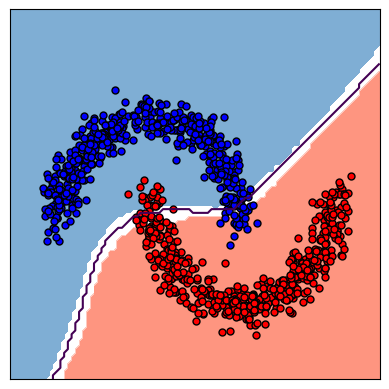

In [54]:
from matplotlib.colors import ListedColormap
N=8
M=40
s=2
### Visualise the results (AGT)
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

ensemble_preds = torch.load(f"{save_dir}/ensemble_preds_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
agt_uncert = torch.tensor(torch.load(f"{save_dir}/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")['z']).to(device)
preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
ax.contour(X0, X1, preds, levels=[0.5])
cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
print((cert_preds == 0).sum())
pastel_red = "#FE2C02"   # Soft pinkish-red
pastel_blue = "#015FAA"  # Light pastel blue
cmap = ListedColormap([pastel_red, "white", pastel_blue])
ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)

# plot the moons
ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

# save fig
plt.savefig(f"../figures/prop_{dpa_prop}_agt_moons_{N}_{M}_{s}_fa.pdf", dpi=300, bbox_inches='tight')

In [6]:
from matplotlib.colors import ListedColormap

def plot_subplot(ax, N, M, s, dpa_prop, save_dir):
    ensemble_preds = torch.load(f"{save_dir}/ensemble_preds_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
    agt_uncert = torch.tensor(torch.load(f"{save_dir}/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")['z']).to(device)
    preds = ensemble_preds.reshape(gridsize, gridsize).cpu().numpy()
    ax.contour(X0, X1, preds, levels=[0.5])
    cert_preds_0 = ((ensemble_preds == 0) & (agt_uncert == 0)).float()  # where the model always predicts class 0
    cert_preds_1 = ((ensemble_preds == 1) & (agt_uncert == 0)).float()  # where the model always predicts class 1
    cert_preds = (cert_preds_0 - cert_preds_1).reshape(gridsize, gridsize).cpu().numpy()
    print((cert_preds == 0).sum())
    pastel_red = "#FE2C02"   # Soft pinkish-red
    pastel_blue = "#015FAA"  # Light pastel blue
    cmap = ListedColormap([pastel_red, "white", pastel_blue])
    ax.contourf(X0, X1, cert_preds, cmap=cmap, levels=[-1.5, -0.5, 0.0, 0.5, 1.5], alpha=0.5)
    
    # plot the moons
    ax.scatter(x_test.cpu()[y_test.cpu() == 0, 0], x_test.cpu()[y_test.cpu() == 0, 1], s=25, edgecolors="k", color="blue")
    ax.scatter(x_test.cpu()[y_test.cpu() == 1, 0], x_test.cpu()[y_test.cpu() == 1, 1], s=25, edgecolors="k", color="red")

278
415
576
512
551


/tmp/ipykernel_3991450/3063876335.py:56: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


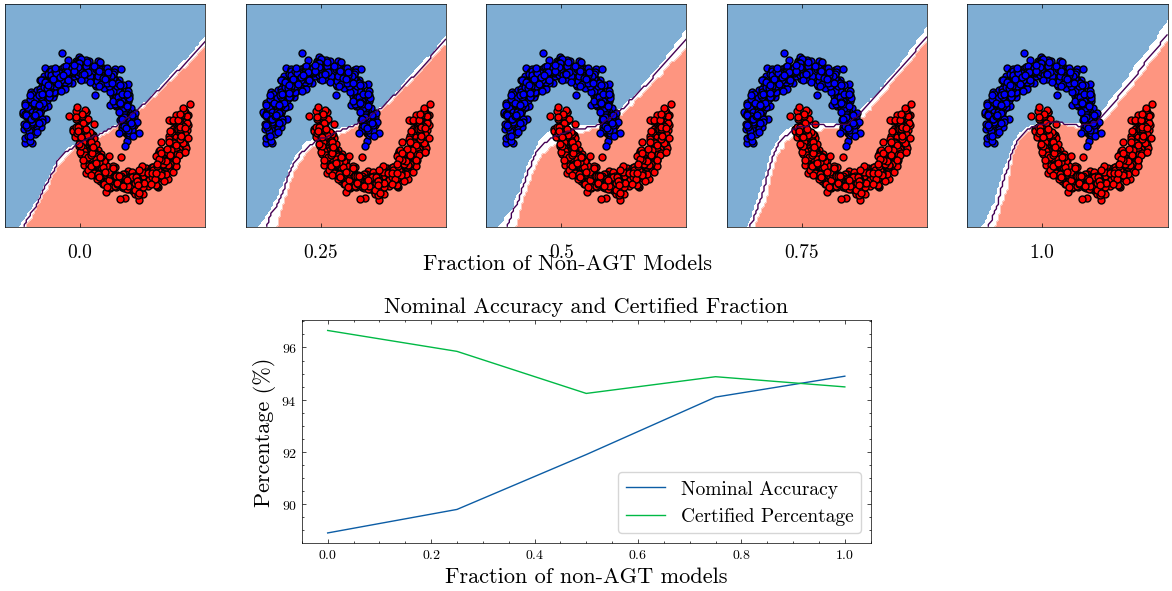

In [59]:
import matplotlib.gridspec as gridspec
plt.style.use(["science", "no-latex"])
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1.2])
gs1 = gridspec.GridSpec(2, 8, height_ratios=[1.2, 1])

# Top row: 3 subplots across all columns
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])

# Bottom row: center 2 plots in columns 1 and 2
ax6 = fig.add_subplot(gs1[1, 2:6])  # spans columns 0 and 1

dpa_props = [0.0, 0.25, 0.5, 0.75, 1.0]
N = 8
M = 40
s = 2
# DPA
# nom_accs = [89.70, 90, 91.90, 93.5, 93.5]
# cs = [95.13, 88.37, 83.98, 80.67, 81.32]
# FA
nom_accs = []
cs = []
for dpa_prop in dpa_props:
    nom_acc = torch.load(f"{save_dir}/nom_acc_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
    nom_accs.append(nom_acc * 100)
    cert_acc = torch.load(f"{save_dir}/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")
    cs.append(cert_acc['cert_acc'] * 100)
    
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    plot_subplot(ax, N, M, s, dpa_props[i], save_dir)
    ax.set_xticks([0])
    ax.set_xticklabels([dpa_props[i]], fontdict={'fontsize': 14})
    for label in ax.get_xticklabels():
        label.set_y(label.get_position()[1] - 0.05)

    # Remove y-axis and spines
    ax.set_yticks([])

# plot line grpah of nom_accs
ax6.plot(dpa_props, nom_accs, label='Nominal Accuracy')
ax6.plot(dpa_props, cs, label='Certified Percentage')
ax6.legend(
    fontsize=14,  # Legend font size
    frameon=True,              # Show legend box
)
ax6.set_xlabel('Fraction of non-AGT models', fontsize=16)
ax6.set_ylabel('Percentage (%)', fontsize=16)
ax6.set_title('Nominal Accuracy and Certified Fraction', fontsize=16)

plt.figtext(0.5, 0.51, 'Fraction of Non-AGT Models', ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.savefig(f"../figures/prop_agt_moons_{N}_{M}_{s}_comparison_fa.pdf", dpi=300, bbox_inches='tight')
plt.show()

278
415
576
512
551


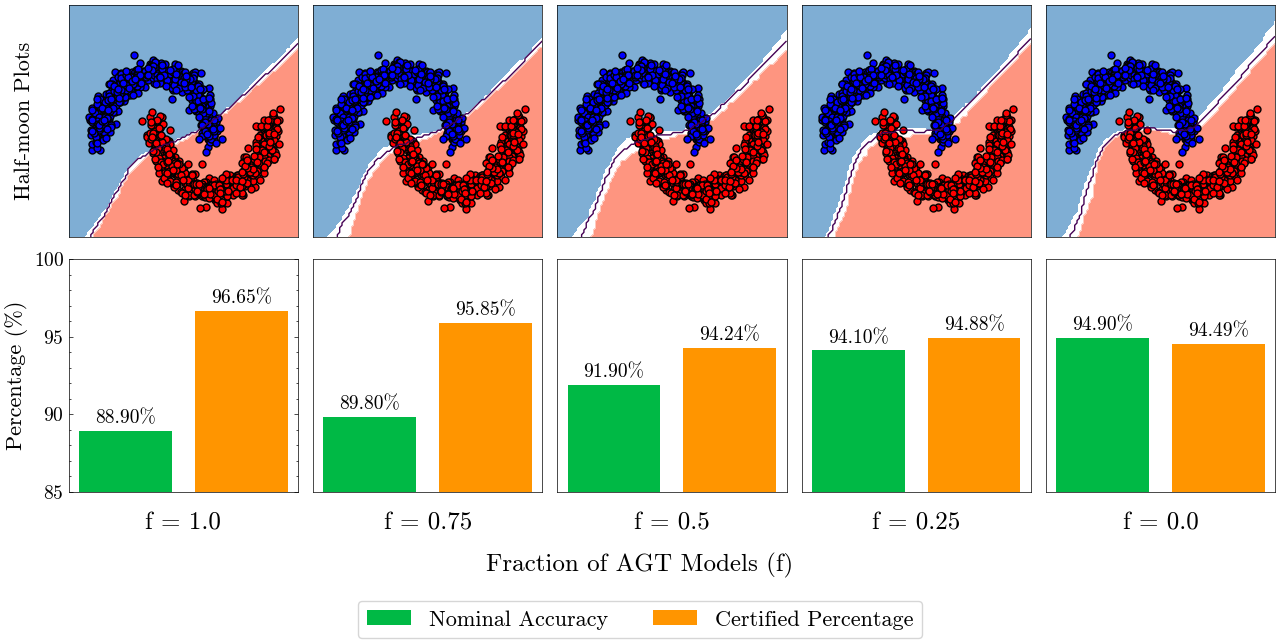

In [12]:
import matplotlib.gridspec as gridspec
plt.style.use(["science", "no-latex"])
fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 1])

# Top row: 3 subplots across all columns
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])


dpa_props = [0.0, 0.25, 0.5, 0.75, 1.0]
N = 8
M = 40
s = 2
# DPA
# nom_accs = [89.70, 90, 91.90, 93.5, 93.5]
# cs = [95.13, 88.37, 83.98, 80.67, 81.32]
# FA
nom_accs = []
cs = []
for dpa_prop in dpa_props:
    nom_acc = torch.load(f"{save_dir}/nom_acc_agt_dpa_{N}_{M}_{s}_{dpa_prop}.pth")
    nom_accs.append(nom_acc * 100)
    cert_acc = torch.load(f"{save_dir}/moons_agt_p_k={N}_{M}_{s}_{dpa_prop}.pth")
    cs.append(cert_acc['cert_acc'] * 100)
    
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    plot_subplot(ax, N, M, s, dpa_props[i], save_dir)
    # Remove y-axis and spines
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel('Half-moon Plots', fontsize=16, labelpad=25)
        ax.tick_params(axis='y', labelsize=14)

xs = ["Nominal Accuracy", "Certified Percentage"]
for i in range(5):
    ax = fig.add_subplot(gs[1, i])
    # plot bar plot with nom_accs and cs
    bar_nom = ax.bar(xs[0], nom_accs[i], color='C1', width=0.8, label='Nominal Accuracy')
    bar_cert = ax.bar(xs[1], cs[i], color='C2', width=0.8, label='Certified Percentage')
    
     # Add labels on bars
    ax.bar_label(bar_nom, labels=[f"{nom_accs[i]:.2f}%"], label_type='edge', padding=3, fontsize=14)
    ax.bar_label(bar_cert, labels=[f"{cs[i]:.2f}%"], label_type='edge', padding=3, fontsize=14)
    if i == 0:
        ax.set_ylabel('Percentage (%)', fontsize=16)
        ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(85, 100)
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    ax.set_xlabel(f"f = {1-dpa_props[i]}", fontdict={'fontsize': 18}, labelpad=15)
    
handles, labels = fig.axes[5].get_legend_handles_labels()
fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        ncol=5,
        frameon=True,
        fontsize=16,  # Legend font size
    )

# plt.figtext(0.5, 0.51, 'Fraction of Non-AGT Models', ha='center', va='center', fontsize=16)
fig.supxlabel('Fraction of AGT Models (f)', fontsize=18, y=0.02)

plt.tight_layout()
plt.savefig(f"../figures/prop_agt_moons_{N}_{M}_{s}_comparison_fa_1.pdf", dpi=300, bbox_inches='tight')
plt.show()